# Summary

This study focuses on honing time series forecasting skills using TensorFlow's DNN capabilities. The initial stages encompassed thorough Exploratory Data Analysis (EDA), inclusive of visualizations, and meticulous data wrangling. Subsequently, I established a basic XGBoost model without hyperparameter tuning, aiming primarily to extract feature importance and set a performance baseline for comparison. Following this, I adapted the data for univariate time series forecasting, utilizing Tensor to create DNN models incorporating LSTM CNN layers. Excitingly, the DNN model exhibited superior performance compared to the XGBoost model in both validation and on the public leaderboard.

As I'm relatively new to this domain, I'm open to feedback and suggestions for improvement. Constructive critique is greatly appreciated, as I'm earnestly learning the ropes. And please rate my notebook if you find it helpful. 

#### Library Importation and Compute Resource Assessment

In [1]:
#Checking GPU to understand how much memory available for training
!nvidia-smi

Wed Dec  6 15:48:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P3             752W /  30W |     53MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
#Enabling memory growth for GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

2023-12-06 15:48:49.331494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 15:48:49.331580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 15:48:49.332880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import IPython
import IPython.display
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
import gc
from tensorflow.keras.callbacks import Callback

In [5]:
# for reproducibility
seed0=1337
np.random.seed(seed0) 
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed0)

In [6]:
#to avoid seeing shortened text data in pandas cell
pd.set_option('display.max_colwidth', None)

# Exploratory Data Analysis, Visualization, and Data Wrangling

In [7]:
#reading datasets
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
holiday_events=pd.read_csv("holidays_events.csv")
oil=pd.read_csv("oil.csv")
stores=pd.read_csv("stores.csv")
transactions=pd.read_csv("transactions.csv")

In [8]:
#checking out dataset content and shape
display("Train",train.head(2),train.tail(2), train.shape, "*"*66)
display("Test",test.head(2),test.tail(2), test.shape, "*"*66)
display("Holiday Events",holiday_events.head(2),holiday_events.tail(2), holiday_events.shape, "*"*66)
display("Oil",oil.head(2),oil.tail(2), oil.shape, "*"*66)
display("Stores",stores.head(2),stores.tail(2), stores.shape, "*"*66)
display("Transactions",transactions.head(2),transactions.tail(1), transactions.shape, "*"*66) 

'Train'

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0

id        date  store_nbr                      family  sales  \
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.0   
3000887  3000887  2017-08-15          9                     SEAFOOD   16.0   

         onpromotion  
3000886            8  
3000887            0

(3000888, 6)

'******************************************************************'

'Test'

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0

id        date  store_nbr                      family  onpromotion
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0

(28512, 5)

'******************************************************************'

'Holiday Events'

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

   transferred  
0        False  
1        False

date        type    locale locale_name description  transferred
348  2017-12-25     Holiday  National     Ecuador     Navidad        False
349  2017-12-26  Additional  National     Ecuador   Navidad+1        False

(350, 6)

'******************************************************************'

'Oil'

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14

date  dcoilwtico
1216  2017-08-30       45.96
1217  2017-08-31       47.26

(1218, 2)

'******************************************************************'

'Stores'

store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13

store_nbr       city   state type  cluster
52         53      Manta  Manabi    D       13
53         54  El Carmen  Manabi    C        3

(54, 5)

'******************************************************************'

'Transactions'

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111

date  store_nbr  transactions
83487  2017-08-15         54           802

(83488, 3)

'******************************************************************'

In [9]:
#converting date feature to datetime data type
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
holiday_events["date"] = pd.to_datetime(holiday_events.date)
oil["date"] = pd.to_datetime(oil.date)
transactions["date"] = pd.to_datetime(transactions.date)

#### Visualising time series data 

In [10]:
#Generic helper function to plot time variant data
def plot_series(time, series, format="-", start=0, end=None):
    fig, ax = plt.subplots(figsize=(14,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

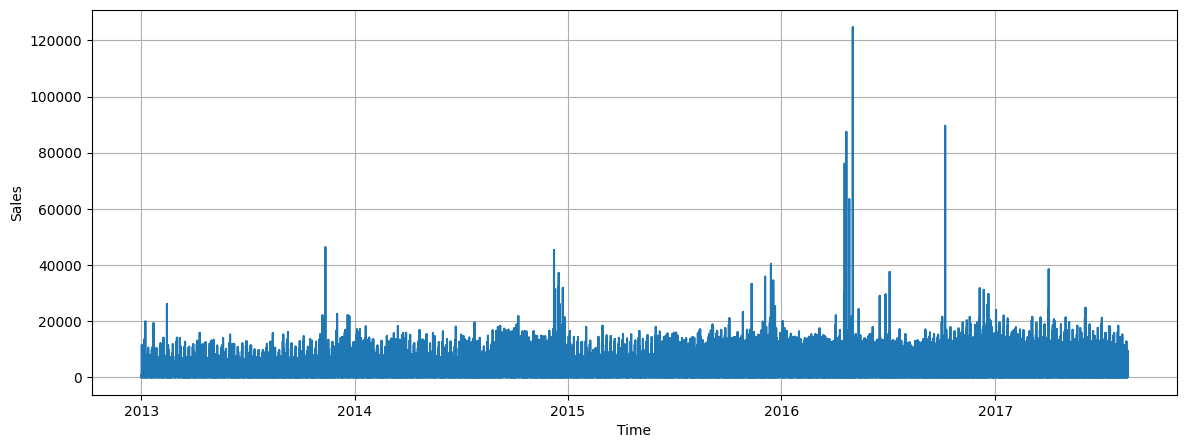

In [11]:
plot_series(train["date"], train["sales"], format="-", start=0, end=None)

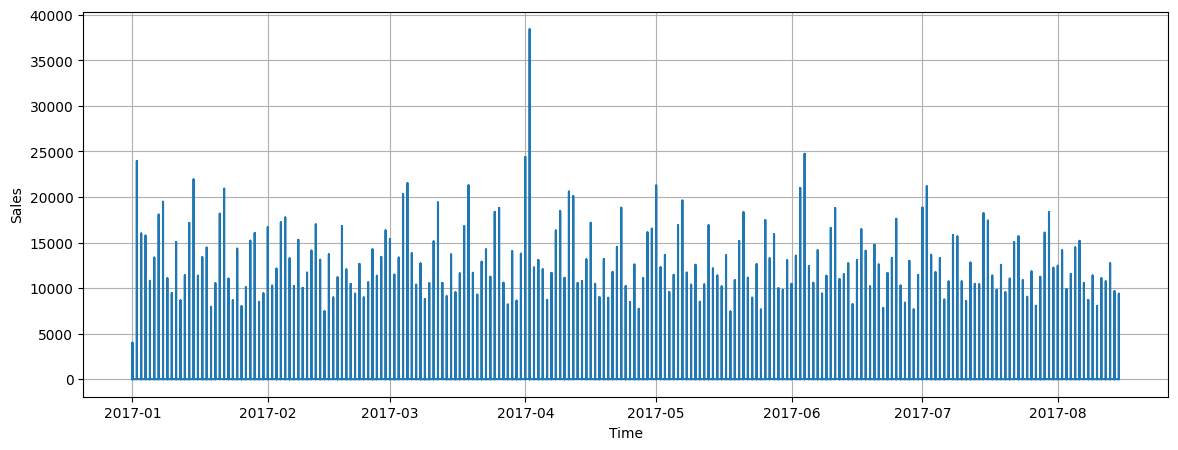

In [12]:
# Zooming into 2017
plot_series(train["date"], train["sales"], format="-",
            start=-len(train["date"][train["date"] >=pd.to_datetime("2017-01-01")]), end=None)

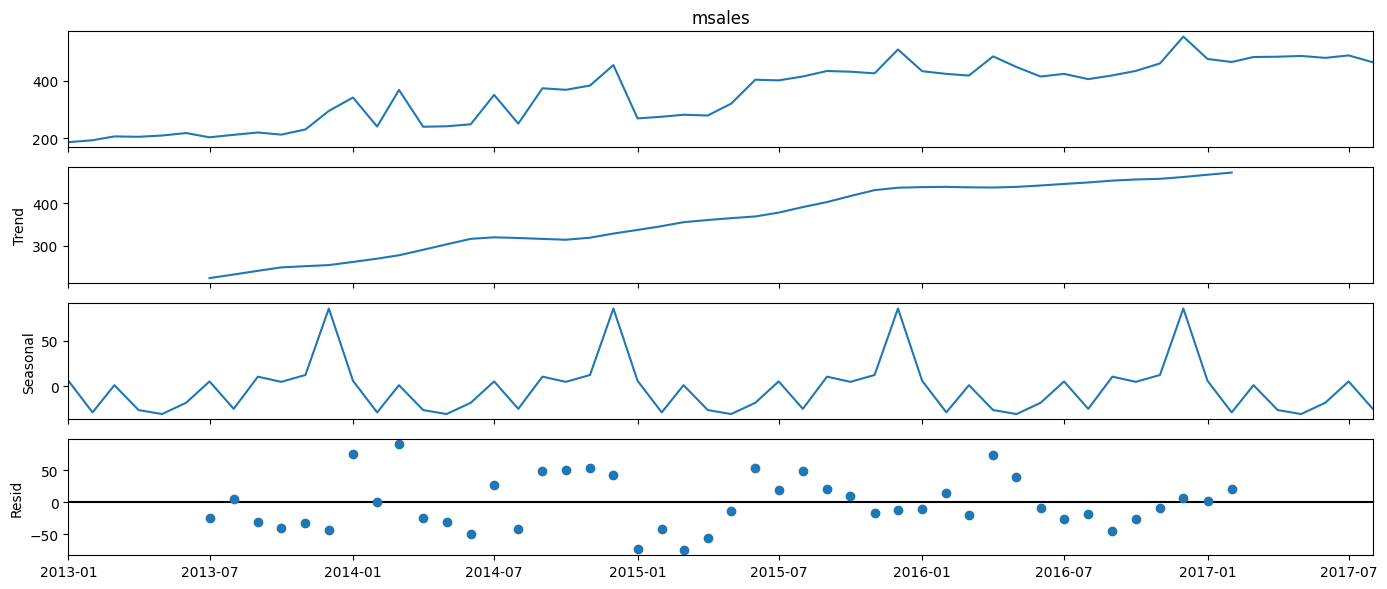

In [13]:
# checking trend seasonality and residuals
import statsmodels.api as sm
t_series = train.groupby(['date'])['sales'].agg(['mean']).reset_index().rename(columns={'mean': 'msales'})
t_series = t_series.set_index('date')
sample= t_series['msales'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(sample, model='additive')
fig = decomposition.plot()
fig.set_size_inches((14, 6))
fig.tight_layout()
plt.show()
plt.close()

### Joining holiday-oil-stores with train and test sets 

Note: I won't use transactions data because it isn't available for test set and I don't want to dedicate time to extract features utilising it but it can certainly provide useful information and worth engineering in a deeper study.

In [14]:
# helper function to do merge datasets 
def joins(df,holiday_events,oil,stores):
    print(df.shape)
    holiday_events=holiday_events.drop_duplicates(subset=['date'], keep='last')
    df_holiday=pd.merge(df,holiday_events,how="left",on='date', validate="many_to_one")
    print(f"Shape after merging with holiday {df_holiday.shape}")
    df_holiday_oil=pd.merge(df_holiday,oil,how="left",on='date')
    print(f"Shape after merging with holiday + oil {df_holiday_oil.shape}")
    df_holiday_oil_stores=pd.merge(df_holiday_oil,stores,how="left",on="store_nbr",suffixes=("holiday","stores"))
    print(f"Shape after merging with holiday + oil + stores {df_holiday_oil_stores.shape}")
    return df_holiday_oil_stores

In [15]:
#merging datasets
train_merged=joins(train,holiday_events,oil,stores)
display(train_merged.head(1),train_merged.tail(1))
test_merged=joins(test,holiday_events,oil,stores)
display(test_merged.head(1),test_merged.tail(1))

(3000888, 6)
Shape after merging with holiday (3000888, 11)
Shape after merging with holiday + oil (3000888, 12)
Shape after merging with holiday + oil + stores (3000888, 16)


id       date  store_nbr      family  sales  onpromotion typeholiday  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0     Holiday   

     locale locale_name         description transferred  dcoilwtico   city  \
0  National     Ecuador  Primer dia del ano       False         NaN  Quito   

       state typestores  cluster  
0  Pichincha          D       13

id       date  store_nbr   family  sales  onpromotion  \
3000887  3000887 2017-08-15          9  SEAFOOD   16.0            0   

        typeholiday locale locale_name            description transferred  \
3000887     Holiday  Local    Riobamba  Fundacion de Riobamba       False   

         dcoilwtico   city      state typestores  cluster  
3000887       47.57  Quito  Pichincha          B        6

(28512, 5)
Shape after merging with holiday (28512, 10)
Shape after merging with holiday + oil (28512, 11)
Shape after merging with holiday + oil + stores (28512, 15)


id       date  store_nbr      family  onpromotion typeholiday locale  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0         NaN    NaN   

  locale_name description transferred  dcoilwtico   city      state  \
0         NaN         NaN         NaN        46.8  Quito  Pichincha   

  typestores  cluster  
0          D       13

id       date  store_nbr   family  onpromotion typeholiday locale  \
28511  3029399 2017-08-31          9  SEAFOOD            0         NaN    NaN   

      locale_name description transferred  dcoilwtico   city      state  \
28511         NaN         NaN         NaN       47.26  Quito  Pichincha   

      typestores  cluster  
28511          B        6

### Extracting month and weekday

In [16]:
# extracting time features for train dataset
train_merged['day_of_week'] = train_merged['date'].dt.day_of_week
train_merged['day_of_week'] = train_merged['day_of_week']+1
train_merged['month'] = train_merged['date'].dt.month
train_merged['year'] = train_merged['date'].dt.year

In [17]:
# extracting time features for test dataset
test_merged['day_of_week'] = test_merged['date'].dt.day_of_week
test_merged['day_of_week'] = test_merged['day_of_week']+1
test_merged['month'] = test_merged['date'].dt.month
test_merged['year'] = test_merged['date'].dt.year

In [18]:
# printing basic properties of features
display(train_merged.describe(include="all").T,train_merged.isna().sum() )
display(test_merged.describe(include="all").T,test_merged.isna().sum())

count unique         top     freq  \
id           3000888.0    NaN         NaN      NaN   
date           3000888    NaN         NaN      NaN   
store_nbr    3000888.0    NaN         NaN      NaN   
family         3000888     33  AUTOMOTIVE    90936   
sales        3000888.0    NaN         NaN      NaN   
onpromotion  3000888.0    NaN         NaN      NaN   
typeholiday     449064      6     Holiday   263736   
locale          449064      3    National   249480   
locale_name     449064     22     Ecuador   249480   
description     449064     97    Carnaval    17820   
transferred     449064      2       False   433026   
dcoilwtico   2072466.0    NaN         NaN      NaN   
city           3000888     22       Quito  1000296   
state          3000888     16   Pichincha  1055868   
typestores     3000888      5           D  1000296   
cluster      3000888.0    NaN         NaN      NaN   
day_of_week  3000888.0    NaN         NaN      NaN   
month        3000888.0    NaN         NaN      NaN   
year         3000888.0    NaN         NaN      NaN   

                                      mean                  min  \
id                               1500443.5                  0.0   
date         2015-04-24 08:27:04.703088384  2013-01-01 00:00:00   
store_nbr                             27.5                  1.0   
family                                 NaN                  NaN   
sales                           357.775749                  0.0   
onpromotion                        2.60277                  0.0   
typeholiday                            NaN                  NaN   
locale                                 NaN                  NaN   
locale_name                            NaN                  NaN   
description                            NaN                  NaN   
transferred                            NaN                  NaN   
dcoilwtico                       67.925589                26.19   
city                                   NaN                  NaN   
state                                  NaN                  NaN   
typestores                             NaN                  NaN   
cluster                           8.481481                  1.0   
day_of_week                       3.997031                  1.0   
month                             6.207838                  1.0   
year                           2014.837886               2013.0   

                             25%                  50%                  75%  \
id                     750221.75            1500443.5           2250665.25   
date         2014-02-26 18:00:00  2015-04-24 12:00:00  2016-06-19 06:00:00   
store_nbr                   14.0                 27.5                 41.0   
family                       NaN                  NaN                  NaN   
sales                        0.0                 11.0            195.84725   
onpromotion                  0.0                  0.0                  0.0   
typeholiday                  NaN                  NaN                  NaN   
locale                       NaN                  NaN                  NaN   
locale_name                  NaN                  NaN                  NaN   
description                  NaN                  NaN                  NaN   
transferred                  NaN                  NaN                  NaN   
dcoilwtico                 46.38                53.33                 95.8   
city                         NaN                  NaN                  NaN   
state                        NaN                  NaN                  NaN   
typestores                   NaN                  NaN                  NaN   
cluster                      4.0                  8.5                 13.0   
day_of_week                  2.0                  4.0                  6.0   
month                        3.0                  6.0                  9.0   
year                      2014.0               2015.0               2016.0   

                             max  

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
typeholiday    2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dcoilwtico      928422
city                 0
state                0
typestores           0
cluster              0
day_of_week          0
month                0
year                 0
dtype: int64

count unique                  top   freq                 mean  \
id           28512.0    NaN                  NaN    NaN            3015143.5   
date           28512    NaN                  NaN    NaN  2017-08-23 12:00:00   
store_nbr    28512.0    NaN                  NaN    NaN                 27.5   
family         28512     33           AUTOMOTIVE    864                  NaN   
onpromotion  28512.0    NaN                  NaN    NaN             6.965383   
typeholiday     1782      1              Holiday   1782                  NaN   
locale          1782      1                Local   1782                  NaN   
locale_name     1782      1               Ambato   1782                  NaN   
description     1782      1  Fundacion de Ambato   1782                  NaN   
transferred     1782      1                False   1782                  NaN   
dcoilwtico   21384.0    NaN                  NaN    NaN            47.243333   
city           28512     22                Quito   9504                  NaN   
state          28512     16            Pichincha  10032                  NaN   
typestores     28512      5                    D   9504                  NaN   
cluster      28512.0    NaN                  NaN    NaN             8.481481   
day_of_week  28512.0    NaN                  NaN    NaN               3.9375   
month        28512.0    NaN                  NaN    NaN                  8.0   
year         28512.0    NaN                  NaN    NaN               2017.0   

                             min                  25%                  50%  \
id                     3000888.0           3008015.75            3015143.5   
date         2017-08-16 00:00:00  2017-08-19 18:00:00  2017-08-23 12:00:00   
store_nbr                    1.0                 14.0                 27.5   
family                       NaN                  NaN                  NaN   
onpromotion                  0.0                  0.0                  0.0   
typeholiday                  NaN                  NaN                  NaN   
locale                       NaN                  NaN                  NaN   
locale_name                  NaN                  NaN                  NaN   
description                  NaN                  NaN                  NaN   
transferred                  NaN                  NaN                  NaN   
dcoilwtico                 45.96               46.715                47.25   
city                         NaN                  NaN                  NaN   
state                        NaN                  NaN                  NaN   
typestores                   NaN                  NaN                  NaN   
cluster                      1.0                  4.0                  8.5   
day_of_week                  1.0                 2.75                  4.0   
month                        8.0                  8.0                  8.0   
year                      2017.0               2017.0               2017.0   

                             75%                  max          std  
id                    3022271.25            3029399.0  8230.849774  
date         2017-08-27 06:00:00  2017-08-31 00:00:00          NaN  
store_nbr                   41.0                 54.0    15.586057  
family                       NaN                  NaN          NaN  
onpromotion                  6.0                646.0    20.683952  
typeholiday                  NaN                  NaN          NaN  
locale                       NaN                  NaN          NaN  
locale_name                  NaN                  NaN          NaN  
description                  NaN                  NaN          NaN  
transferred                  NaN                  NaN          NaN  
dcoilwtico                 47.65                48.59     0.753922  
city                         NaN                  NaN          NaN  
state                        NaN                  NaN          NaN  
typestores                   NaN             

id                 0
date               0
store_nbr          0
family             0
onpromotion        0
typeholiday    26730
locale         26730
locale_name    26730
description    26730
transferred    26730
dcoilwtico      7128
city               0
state              0
typestores         0
cluster            0
day_of_week        0
month              0
year               0
dtype: int64

### Changing transfered holidays to normal days

In [19]:
#checking value counts of holiday types
display(train_merged["typeholiday"].value_counts(dropna=False))
# checking categories of transferred feature of holiday dataset
display(train_merged["transferred"].unique())

typeholiday
NaN           2551824
Holiday        263736
Event           98010
Additional      58806
Transfer        16038
Work Day         8910
Bridge           3564
Name: count, dtype: int64

array([False, nan, True], dtype=object)

In [20]:
# helper function to convert transfered holidays to normal days
def transfer_holiday_fix(df):
    df["typeholiday"]=np.where(df["transferred"]==True,'NDay',df["typeholiday"])
    df["typeholiday"]=np.where(df["typeholiday"]=='Work Day','NDay',df["typeholiday"])
    df["typeholiday"]=df["typeholiday"].fillna("NDay")
    return df

In [21]:
train_merged=transfer_holiday_fix(train_merged)
test_merged=transfer_holiday_fix(test_merged)
# checking new structure of holiday type column
display(train_merged["typeholiday"].value_counts(dropna=False))
display(test_merged["typeholiday"].value_counts(dropna=False))

typeholiday
NDay          2576772
Holiday        247698
Event           98010
Additional      58806
Transfer        16038
Bridge           3564
Name: count, dtype: int64

typeholiday
NDay       26730
Holiday     1782
Name: count, dtype: int64

#### Removing the key columns

In [22]:
#helper function to remove id columns used for joining datasets, 
# note I made decision not to use store_nbr, because I am not using transactions to extract features
# but it can work as category feature for certain models, 
# my decision was because it is an idendifier and useful information it contains also exist in store type and cluster
def select_relevant(df):
    print(f"shape before removing columns {df.shape}")
    features=["date","family","sales","onpromotion","typeholiday","dcoilwtico","city","state",
              "typestores","cluster","day_of_week","month","year"]
    if "sales" in df.columns:
        df= df[features]
    else:
        features.remove("sales")
        df= df[features]
    print(f"Shape after removing columns {df.shape}")
    return df

In [23]:
train_merged=select_relevant(train_merged)
test_merged=select_relevant(test_merged)

shape before removing columns (3000888, 19)
Shape after removing columns (3000888, 13)
shape before removing columns (28512, 18)
Shape after removing columns (28512, 12)


### Fixing the issue with missing values in oil prices by interpolating nans and 0s at oil price

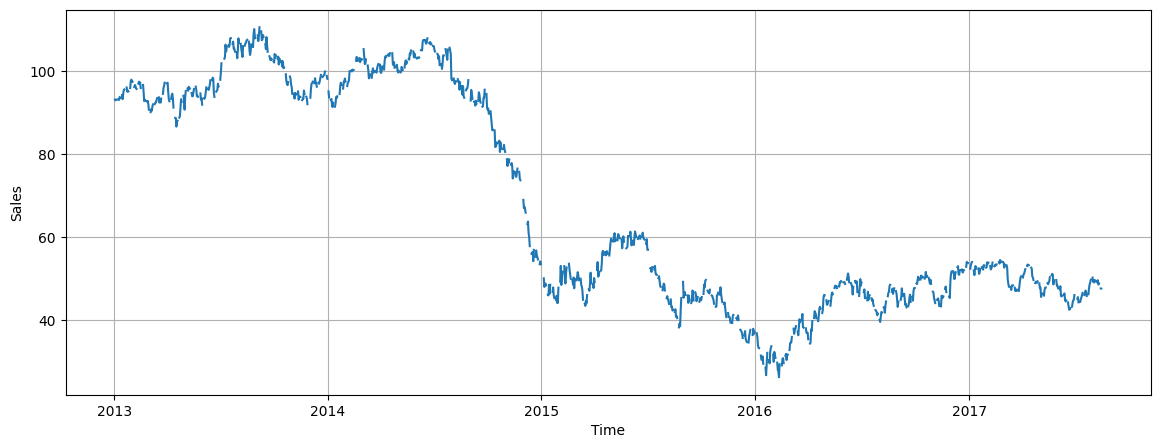

In [24]:
# plotting current distribution of oil price vs time
plot_series(train_merged["date"], train_merged["dcoilwtico"], format="-", start=0, end=None)

In [25]:
# helper function to interpolate oil price
def interpolate_oil(df):
    print(f"Shape before interpolating {df.shape}")
    df["dcoilwtico"]=np.where(df["dcoilwtico"] ==0, np.nan, df["dcoilwtico"])
    df.dcoilwtico.interpolate(limit_direction='both',inplace=True)
    print(f"Shape after interpolating {df.shape}")
    return df

In [26]:
train_merged=interpolate_oil(train_merged)
test_merged=interpolate_oil(test_merged)
display(f"Number of nan in train dataset oil price after interpolation {train_merged['dcoilwtico'].isna().sum()}")
display(f"Number of nan in test dataset oil price after interpolation {test_merged['dcoilwtico'].isna().sum()}")

Shape before interpolating (3000888, 13)
Shape after interpolating (3000888, 13)
Shape before interpolating (28512, 12)
Shape after interpolating (28512, 12)


'Number of nan in train dataset oil price after interpolation 0'

'Number of nan in test dataset oil price after interpolation 0'

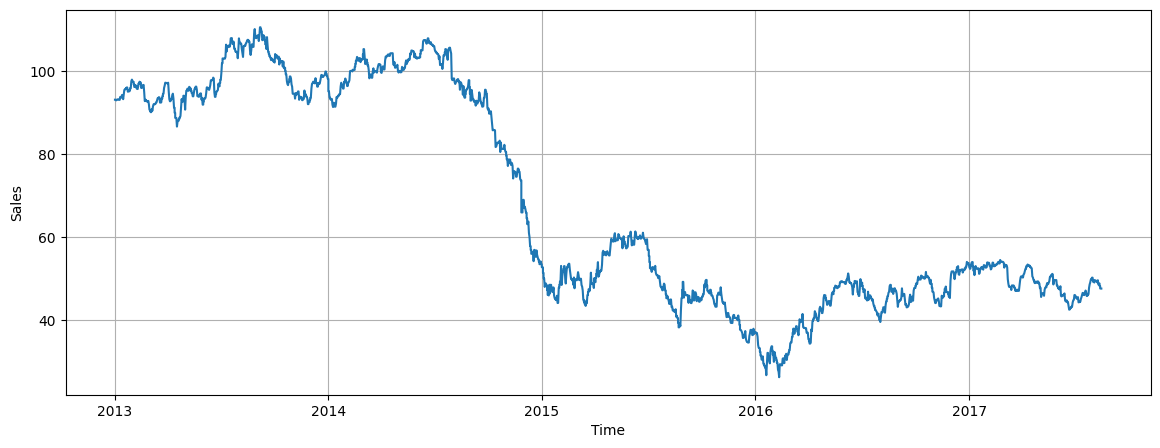

In [27]:
plot_series(train_merged["date"], train_merged["dcoilwtico"], format="-", start=0, end=None)

### Visualising change in signal based on features

In [28]:
# globally setting sns to darkgrid theme
sns.set_theme(style="darkgrid")

In [29]:
# helper function to plot variation of sales vs time for each class in a feature
def plot_by_category(df,category):
    fig, ax = plt.subplots(figsize=(14,8))
    
    df_grouped=df.groupby(['date',category]).agg({'sales': 'mean'}).reset_index()
    sns.lineplot(data =df_grouped,  x="date", y="sales", hue=category, ax=ax, legend="brief")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

family


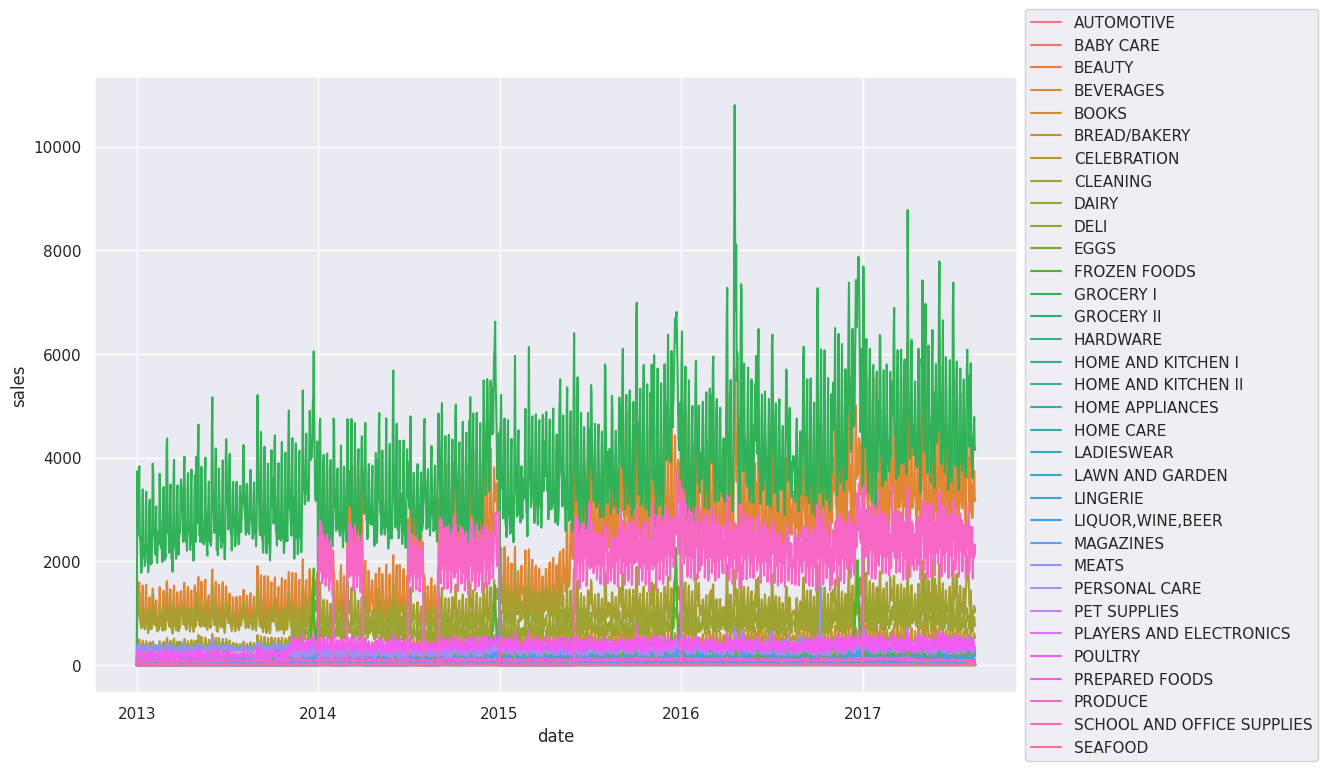

typeholiday


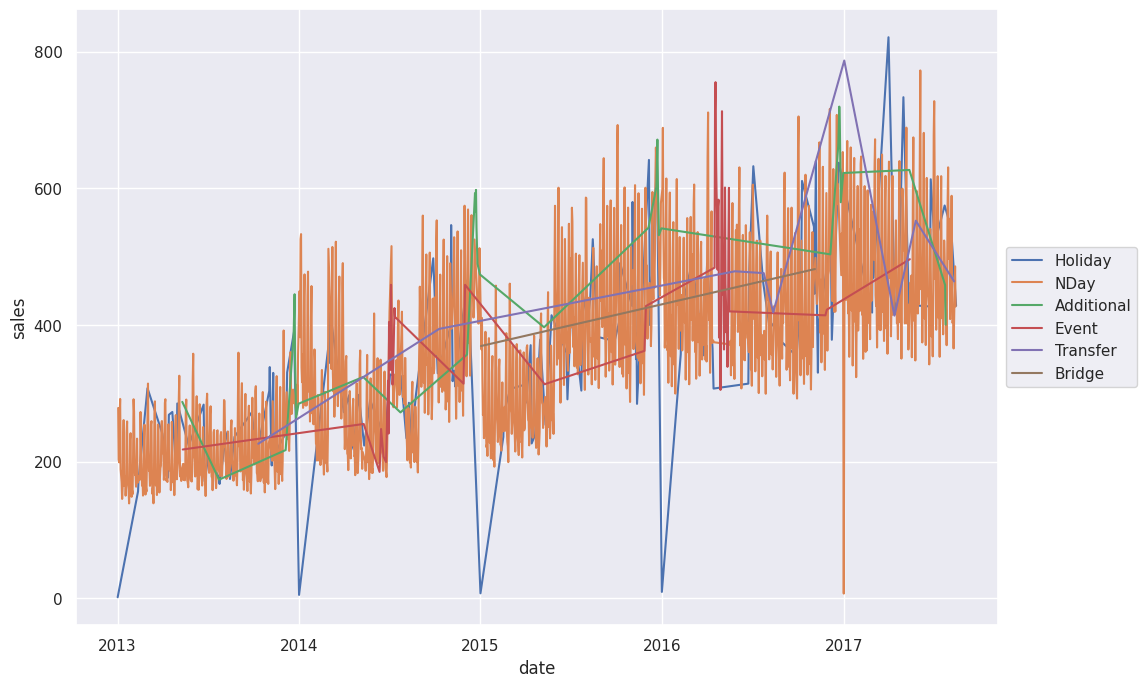

city


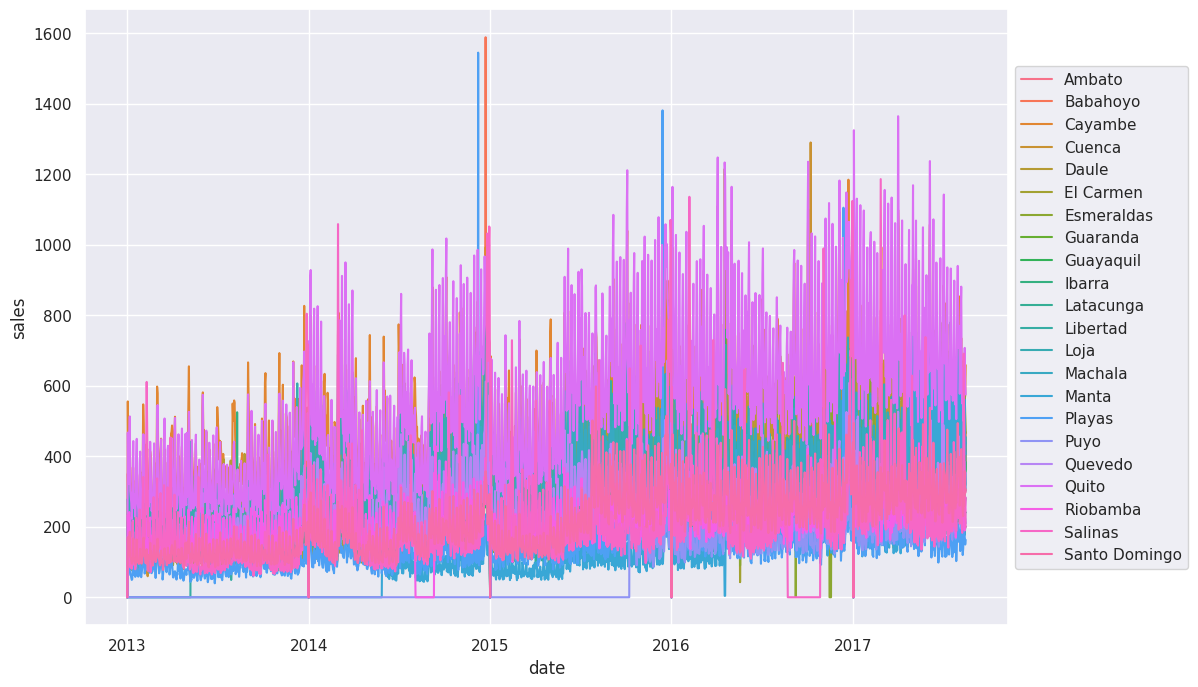

state


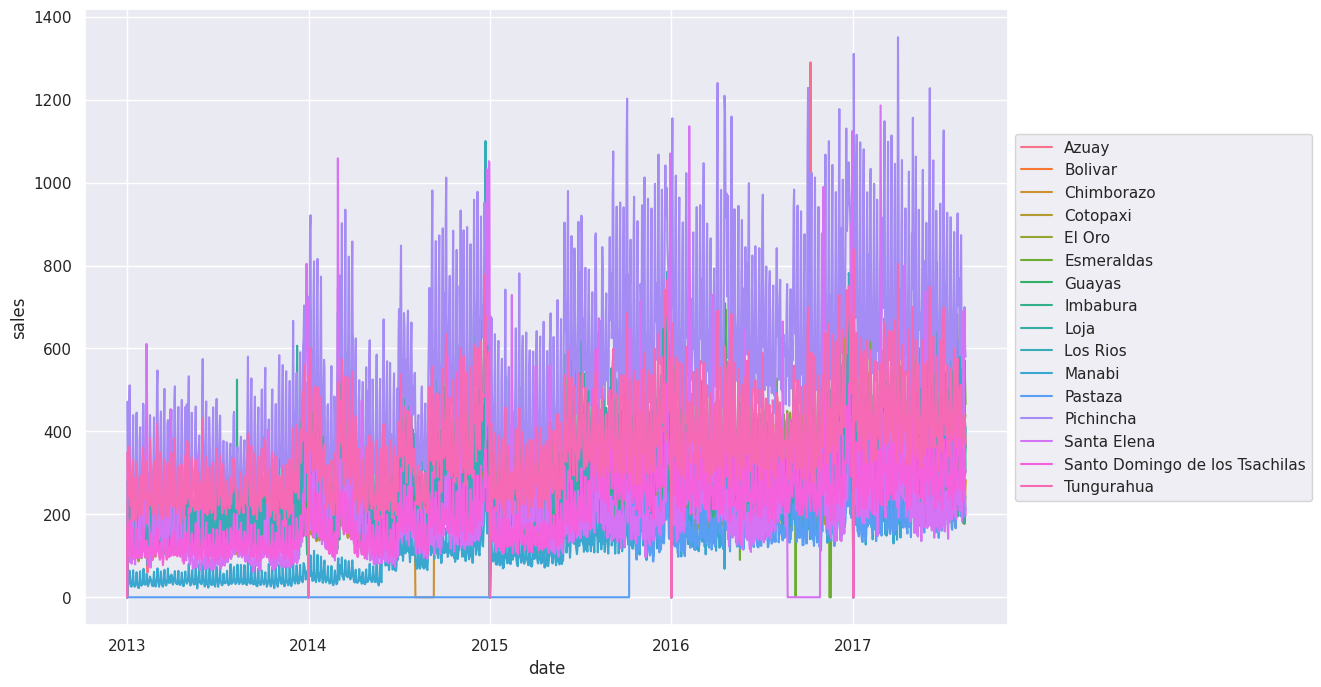

typestores


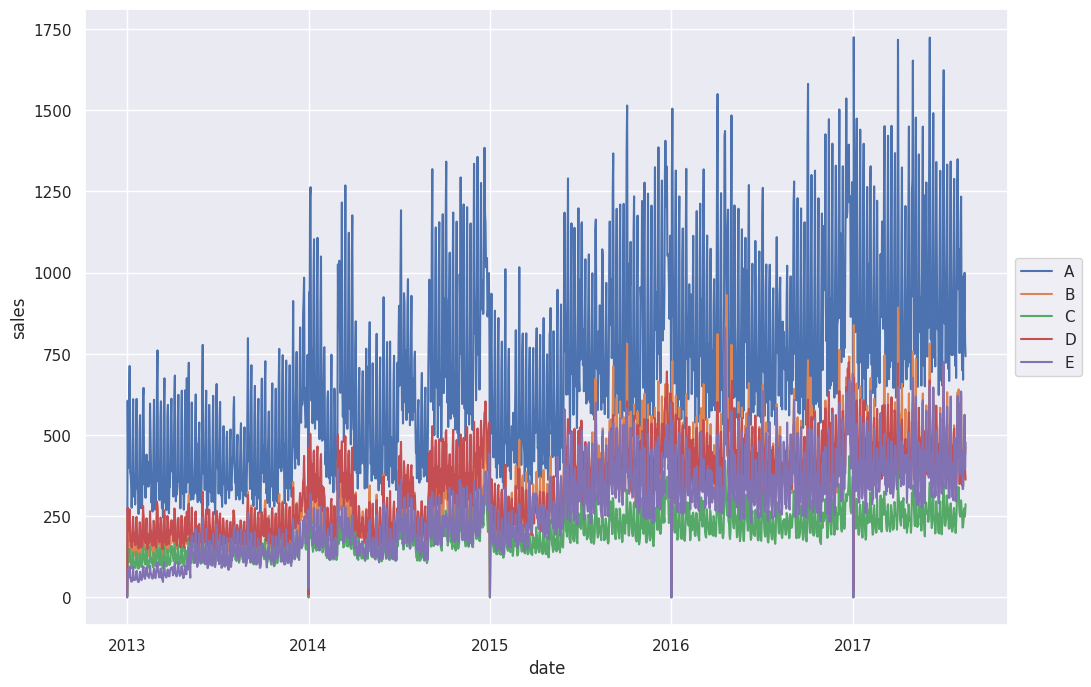

cluster


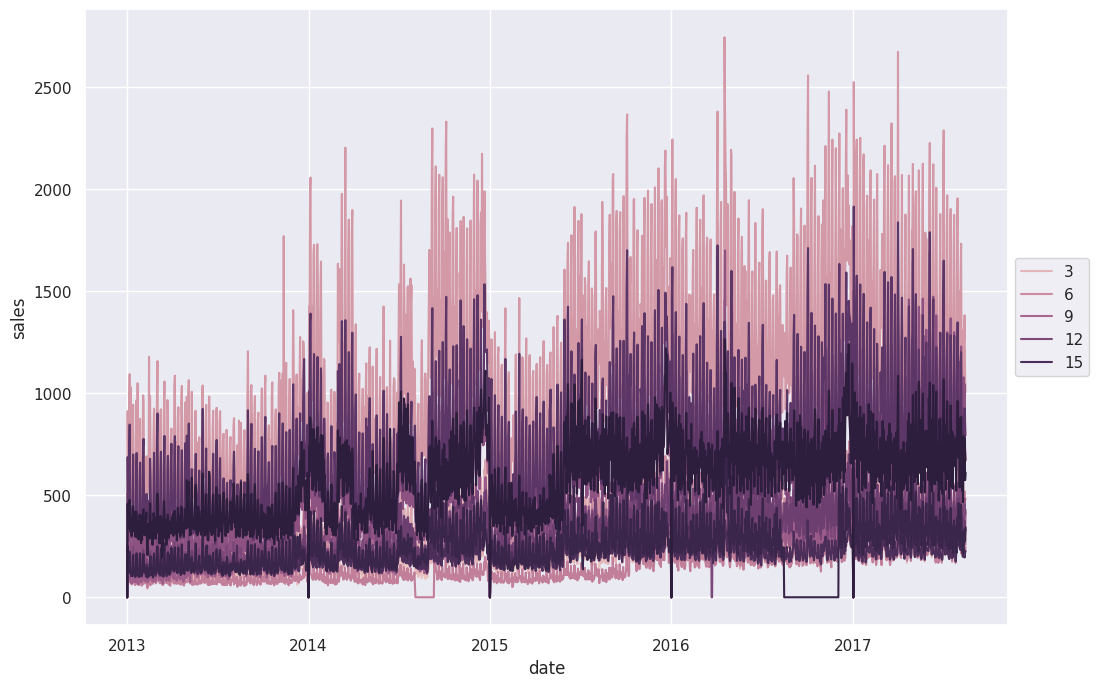

In [30]:
categoricals=[ 'family', 'typeholiday', 'city', 'state', 'typestores', 'cluster']
for cat in categoricals:
    print(cat)
    plot_by_category(train_merged,cat)

day_of_week


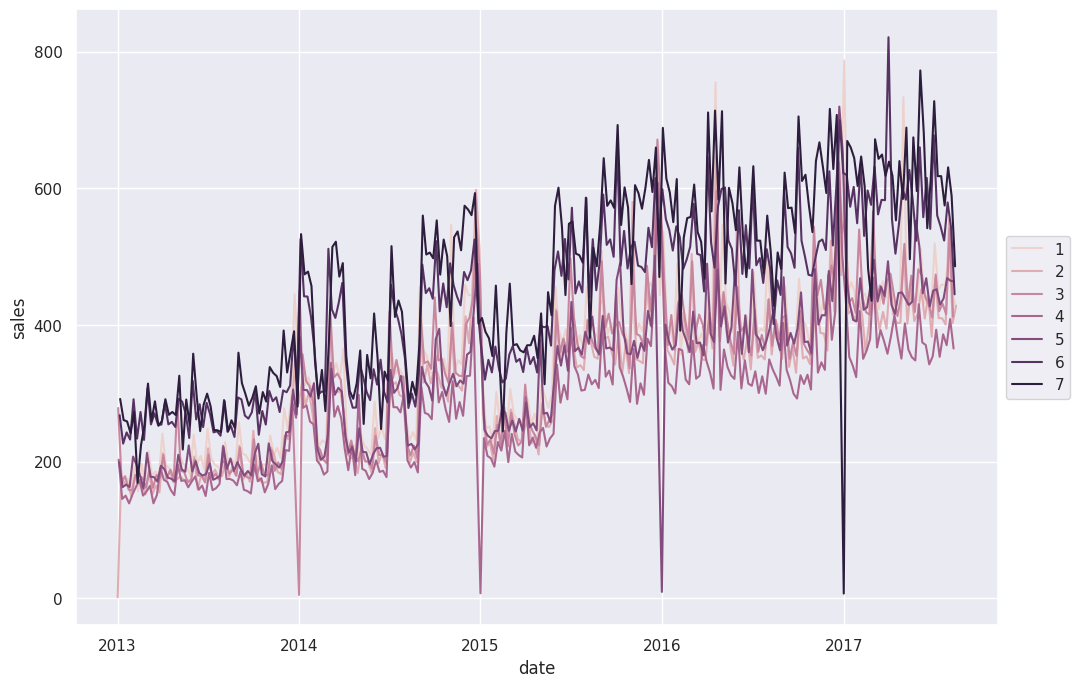

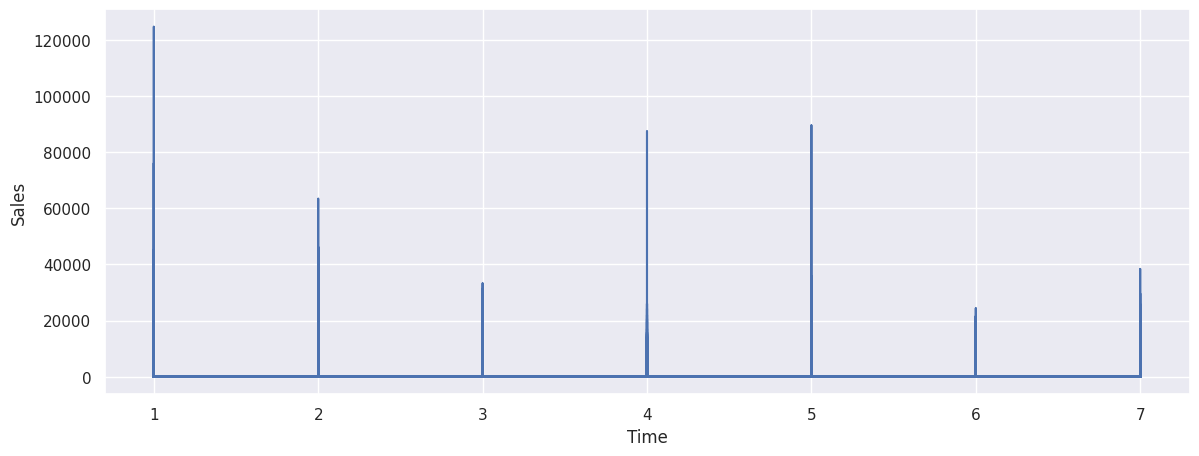

month


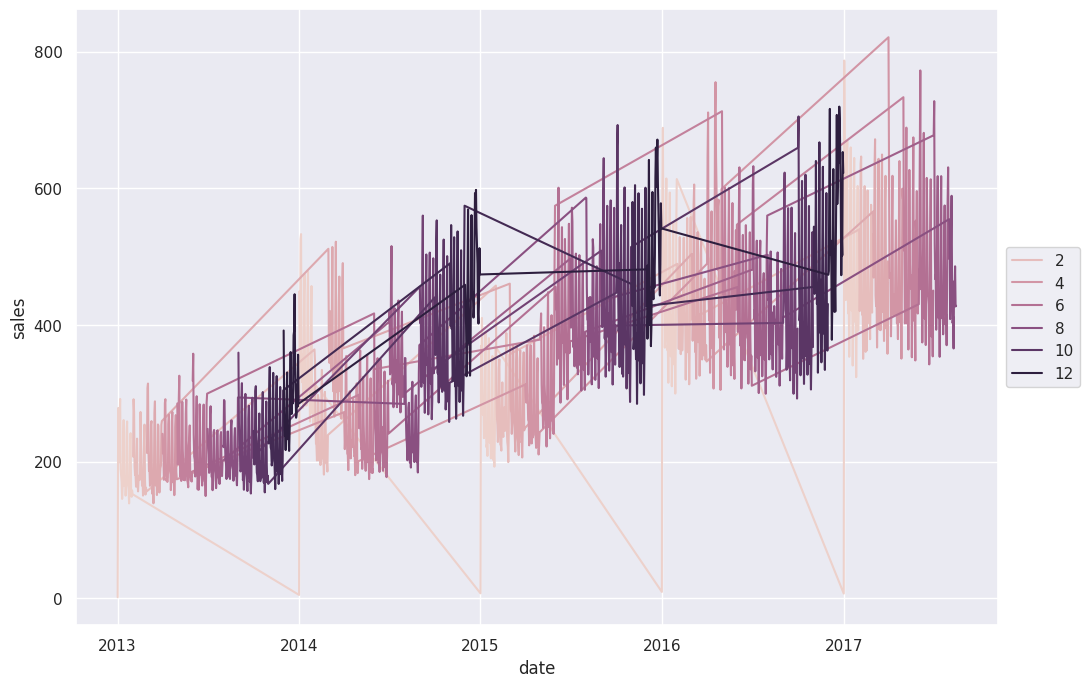

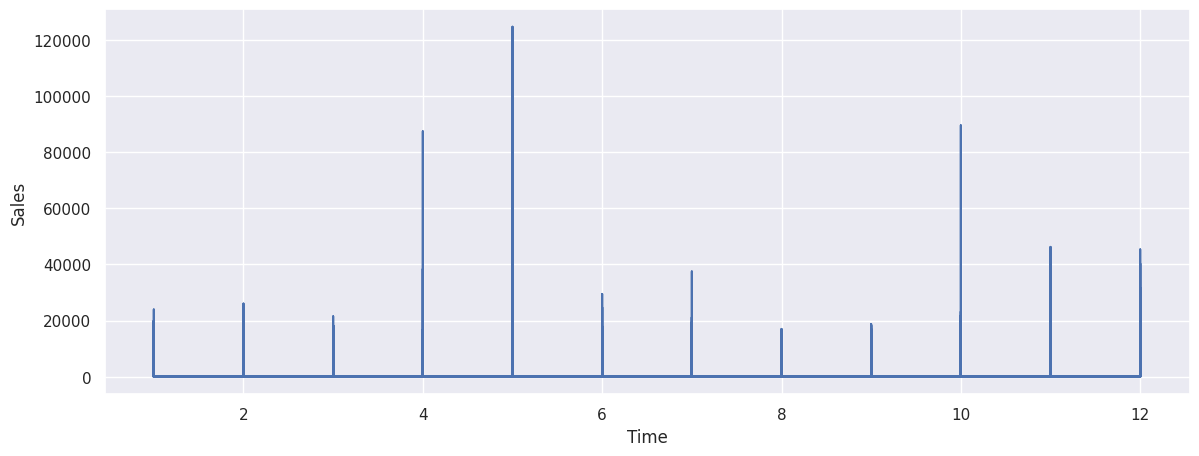

year


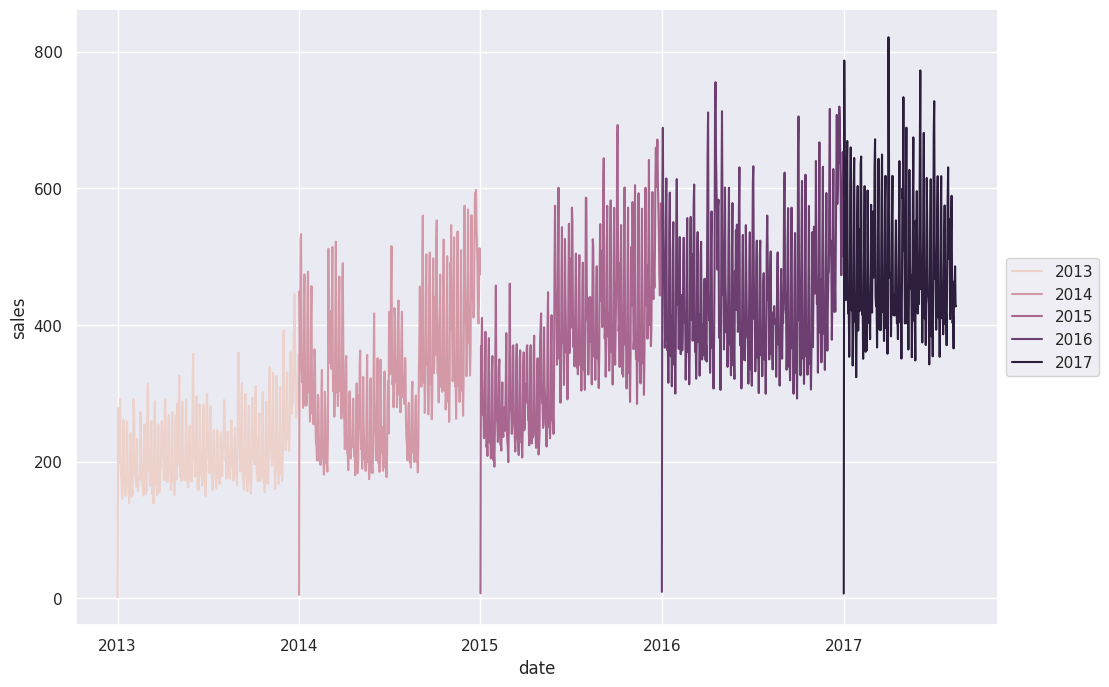

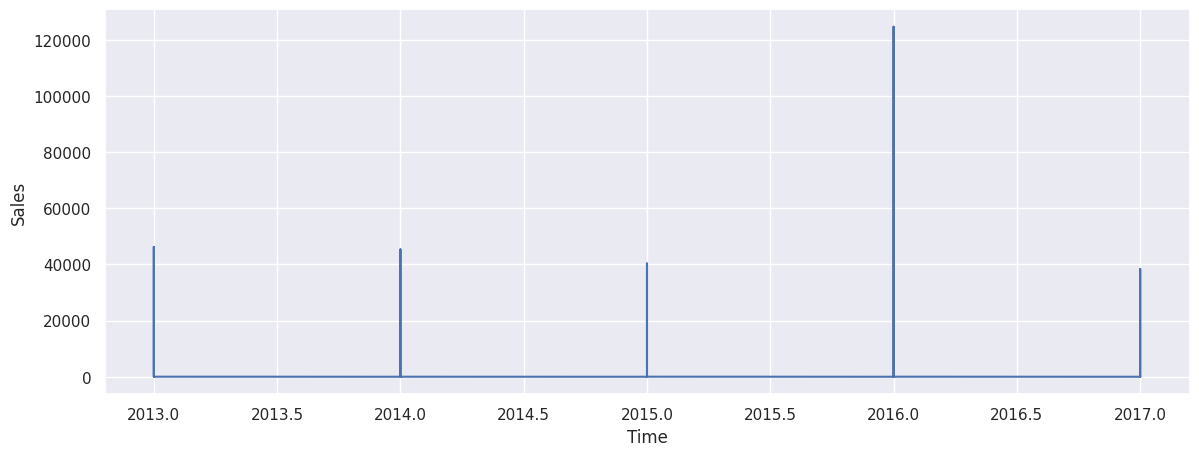

In [31]:
time_features=["day_of_week","month","year"]
for t_feat in time_features:
    print(t_feat)
    plot_by_category(train_merged,t_feat)
    plot_series(train_merged[t_feat], train_merged["sales"], format="-", start=0, end=None)

State and city have very similiar baseline I will use city as it is more specific

In [32]:
# helper function to plot numeric features vs time in comparison to sales vs time
def plot_by_numeric(df,num_cols):
    fig, ax = plt.subplots(figsize=(14,8))
    cols_to_plot=["date","sales",num_cols]
    df=df[cols_to_plot]
    df_grouped=df.groupby(['date']).agg({'sales': 'mean', num_cols:'mean'}).reset_index()
    g1=sns.lineplot(data=df_grouped, x ="date", y='sales',legend='full', ax=ax)
    g2=sns.lineplot(data=df_grouped, x ="date", y=num_cols,legend='full', ax=ax)
    g1.set(yscale='log')
    g2.set(yscale='log')
    plt.show()
    plt.close()

onpromotion


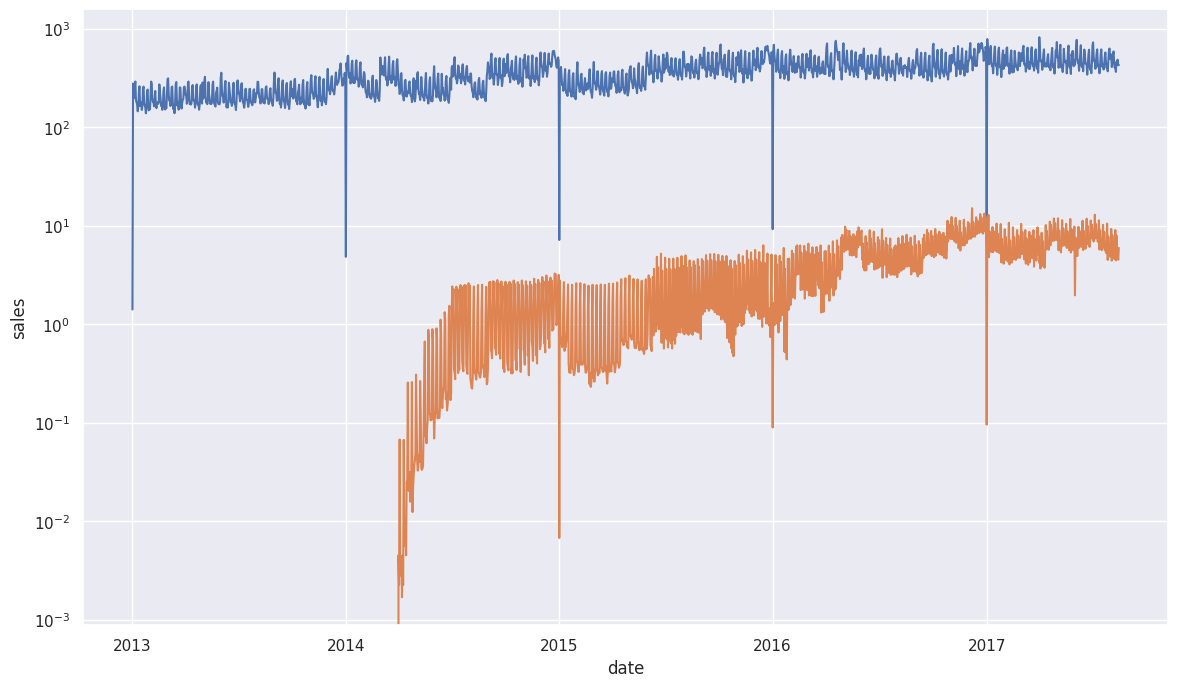

dcoilwtico


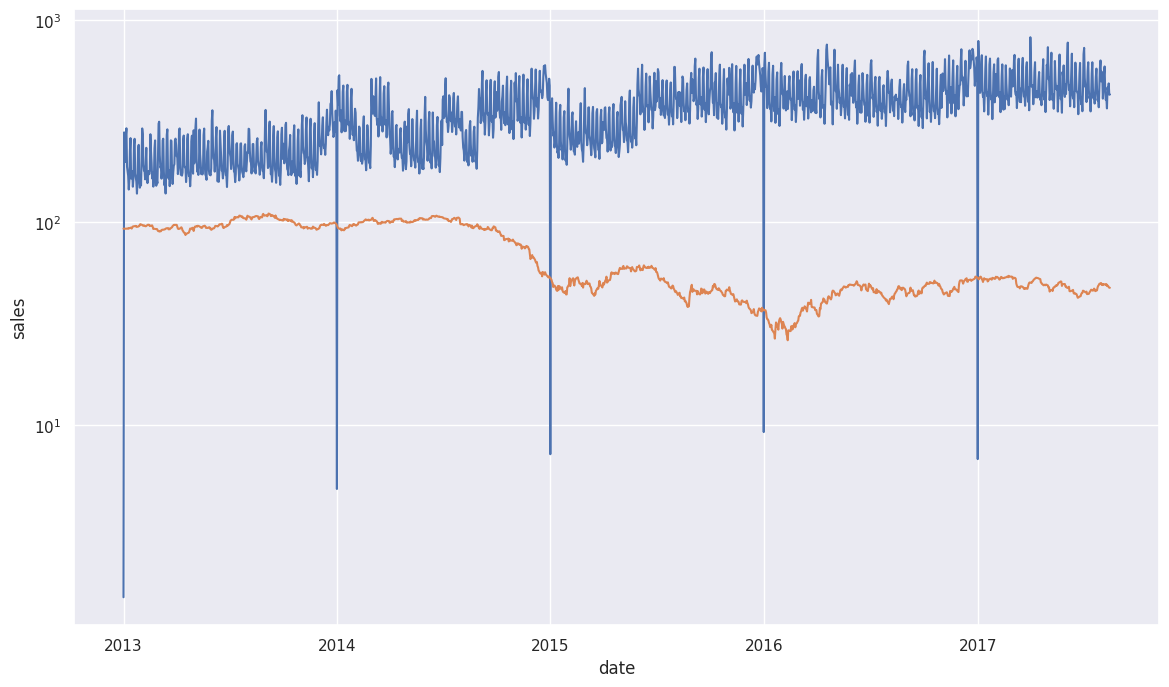

In [33]:
numerics=['onpromotion','dcoilwtico']
for num_col in numerics:
    print(num_col)
    plot_by_numeric(train_merged,num_col)

In [34]:
#helper function to plot numeric features vs time in comparison to sales vs time zooming in after 2017.01.01
def plot_by_numeric_last_year(df,num_cols):
    fig, ax = plt.subplots(figsize=(14,8))
    cols_to_plot=["date","sales",num_cols]
    df=df[cols_to_plot]
    df=df[train["date"] >=pd.to_datetime("2017-01-01")]
    df_grouped=df.groupby(['date']).agg({'sales': 'mean', num_cols:'mean'}).reset_index()
    g1=sns.lineplot(data=df_grouped, x ="date", y='sales', ax=ax)
    g2=sns.lineplot(data=df_grouped, x ="date", y=num_cols, ax=ax)
    g1.set(yscale='log')
    g2.set(yscale='log')
    plt.show()
    plt.close()

onpromotion


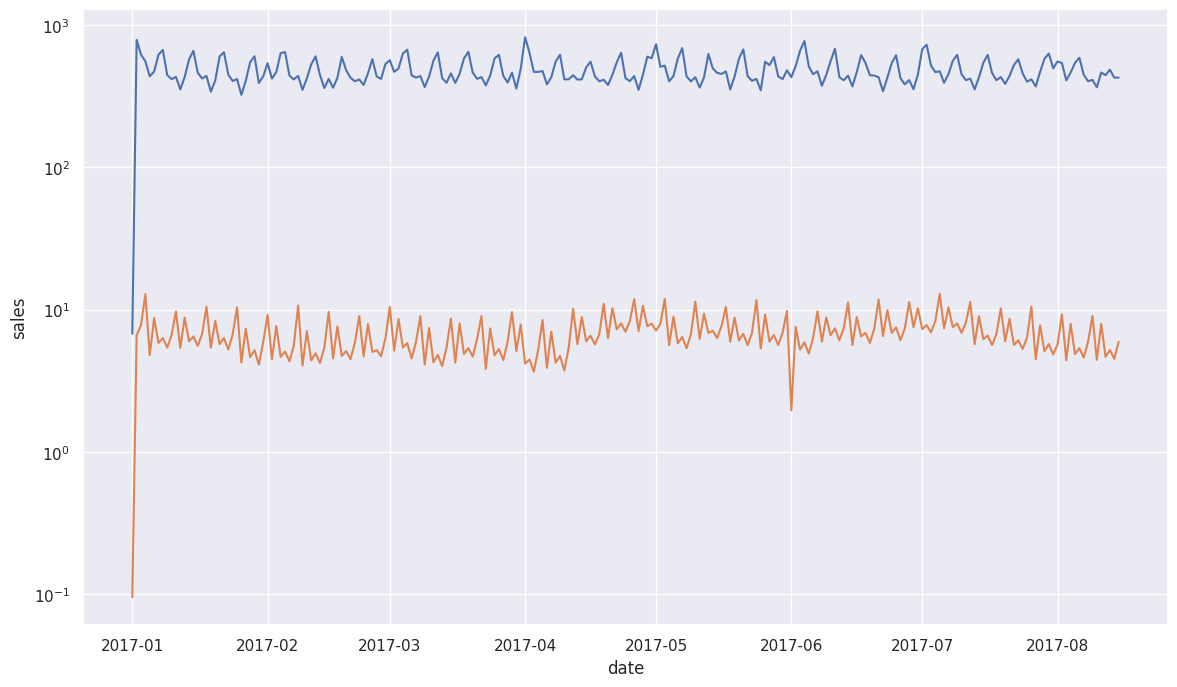

dcoilwtico


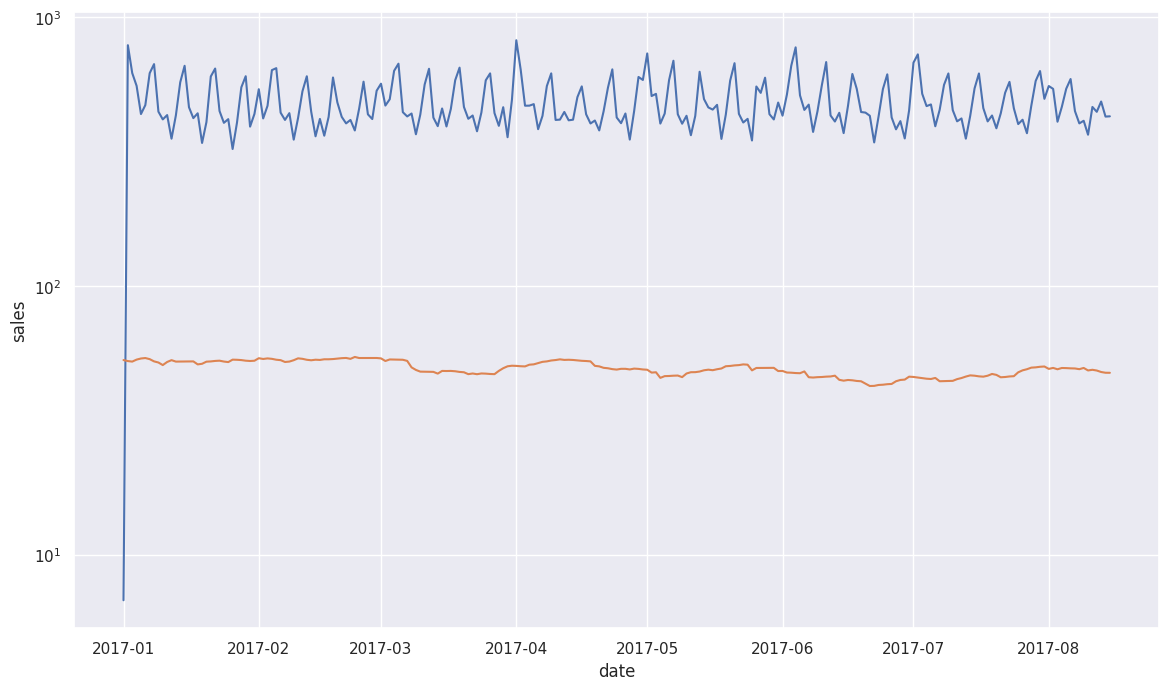

In [35]:
numerics=['onpromotion','dcoilwtico']
for num_col in numerics:
    print(num_col)
    plot_by_numeric_last_year(train_merged,num_col)

In [36]:
# helper function to extract the features I potentially use for training a model
def extract_features(df):
    print(f"Shape before extracting {df.shape}")
    useful_features=['date', 'family','onpromotion','typeholiday', 'dcoilwtico','city', 'typestores', 'cluster','day_of_week', 'month','year']
    if "sales"in df.columns:
        df=df[useful_features+["sales"]]
    else:
        df=df[useful_features]
    print(f"Shape after extracting{df.shape}")
    return df

In [37]:
train_merged=extract_features(train_merged)
test_merged=extract_features(test_merged)

Shape before extracting (3000888, 13)
Shape after extracting(3000888, 12)
Shape before extracting (28512, 12)
Shape after extracting(28512, 11)


In [38]:
# converting category columns to str type
category_columns=['family', 'typeholiday', 'city', 'typestores', 'cluster']
for column in category_columns:
    train_merged[column] = train_merged[column].astype('str')
    test_merged[column] = test_merged[column].astype('str')

In [39]:
# converting extracted time features to float
time_columns=["month","day_of_week","year"]
for column in time_columns:
    train_merged[column] = train_merged[column].astype('float')
    test_merged[column] = test_merged[column].astype('float')

In [40]:
# checking conditions of training and test datasets
display(train_merged.head(2))
display(train_merged.tail(2))
display(train_merged.describe(include="all").T)

date      family  onpromotion typeholiday  dcoilwtico   city  \
0 2013-01-01  AUTOMOTIVE            0     Holiday       93.14  Quito   
1 2013-01-01   BABY CARE            0     Holiday       93.14  Quito   

  typestores cluster  day_of_week  month    year  sales  
0          D      13          2.0    1.0  2013.0    0.0  
1          D      13          2.0    1.0  2013.0    0.0

date                      family  onpromotion typeholiday  \
3000886 2017-08-15  SCHOOL AND OFFICE SUPPLIES            8     Holiday   
3000887 2017-08-15                     SEAFOOD            0     Holiday   

         dcoilwtico   city typestores cluster  day_of_week  month    year  \
3000886       47.57  Quito          B       6          2.0    8.0  2017.0   
3000887       47.57  Quito          B       6          2.0    8.0  2017.0   

         sales  
3000886  121.0  
3000887   16.0

count unique         top     freq  \
date           3000888    NaN         NaN      NaN   
family         3000888     33  AUTOMOTIVE    90936   
onpromotion  3000888.0    NaN         NaN      NaN   
typeholiday    3000888      6        NDay  2576772   
dcoilwtico   3000888.0    NaN         NaN      NaN   
city           3000888     22       Quito  1000296   
typestores     3000888      5           D  1000296   
cluster        3000888     17           3   389004   
day_of_week  3000888.0    NaN         NaN      NaN   
month        3000888.0    NaN         NaN      NaN   
year         3000888.0    NaN         NaN      NaN   
sales        3000888.0    NaN         NaN      NaN   

                                      mean                  min  \
date         2015-04-24 08:27:04.703088384  2013-01-01 00:00:00   
family                                 NaN                  NaN   
onpromotion                        2.60277                  0.0   
typeholiday                            NaN                  NaN   
dcoilwtico                        67.89353                26.19   
city                                   NaN                  NaN   
typestores                             NaN                  NaN   
cluster                                NaN                  NaN   
day_of_week                       3.997031                  1.0   
month                             6.207838                  1.0   
year                           2014.837886               2013.0   
sales                           357.775749                  0.0   

                             25%                  50%                  75%  \
date         2014-02-26 18:00:00  2015-04-24 12:00:00  2016-06-19 06:00:00   
family                       NaN                  NaN                  NaN   
onpromotion                  0.0                  0.0                  0.0   
typeholiday                  NaN                  NaN                  NaN   
dcoilwtico                 46.37            53.303305             95.79115   
city                         NaN                  NaN                  NaN   
typestores                   NaN                  NaN                  NaN   
cluster                      NaN                  NaN                  NaN   
day_of_week                  2.0                  4.0                  6.0   
month                        3.0                  6.0                  9.0   
year                      2014.0               2015.0               2016.0   
sales                        0.0                 11.0            195.84725   

                             max          std  
date         2017-08-15 00:00:00          NaN  
family                       NaN          NaN  
onpromotion                741.0    12.218882  
typeholiday                  NaN          NaN  
dcoilwtico                110.62    25.685176  
city                         NaN          NaN  
typestores                   NaN          NaN  
cluster                      NaN          NaN  
day_of_week                  7.0      2.00074  
month                       12.0     3.385668  
year                      2017.0     1.345518  
sales                   124717.0  1101.997721

In [41]:
# saving them in to a csv
train_merged.to_csv('train_merged.csv', index=False)
test_merged.to_csv('test_merged.csv', index=False)

#### Common libs & Methods for ML 

In [42]:
#main modules for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import TargetEncoder

#main modules for designing ML pipeliens
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

#main module for evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error,r2_score

In [43]:
# helper function to calculate regression metrics
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"RMSLE":[mean_squared_log_error(testActualVal, predictions)**0.5],
         "MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

# XGBoost

### Preprocessing for XGBoost

In [44]:
# helper function to split datset in to train and validation, validation set involves samples after 01.01.2017
def split(df):
    useful_features=['date', 'family','typeholiday','onpromotion', 'dcoilwtico','city', 'typestores',
                     'cluster','day_of_week', 'month','year']
    val_start_index=df.shape[0]-len(df["date"][df["date"] >=pd.to_datetime("2017-01-01")])
    train = df[:val_start_index]
    val=df[val_start_index:]
    X_train = train[useful_features]
    y_train = train["sales"]
    X_valid = val[useful_features]
    y_valid = val["sales"]
    return X_train, y_train, X_valid, y_valid 

In [45]:
X_train, y_train, X_valid, y_valid =split(train_merged)

In [46]:
display(X_train.head(1),X_train.tail(1),X_train.shape )
display(X_valid.head(1),X_valid.tail(1), X_valid.shape)

date      family typeholiday  onpromotion  dcoilwtico   city  \
0 2013-01-01  AUTOMOTIVE     Holiday            0       93.14  Quito   

  typestores cluster  day_of_week  month    year  
0          D      13          2.0    1.0  2013.0

date   family typeholiday  onpromotion  dcoilwtico   city  \
2596373 2016-12-31  SEAFOOD  Additional            2   53.286753  Quito   

        typestores cluster  day_of_week  month    year  
2596373          B       6          6.0   12.0  2016.0

(2596374, 11)

date      family typeholiday  onpromotion  dcoilwtico   city  \
2596374 2017-01-01  AUTOMOTIVE        NDay            0   53.286493  Quito   

        typestores cluster  day_of_week  month    year  
2596374          D      13          7.0    1.0  2017.0

date   family typeholiday  onpromotion  dcoilwtico   city  \
3000887 2017-08-15  SEAFOOD     Holiday            0       47.57  Quito   

        typestores cluster  day_of_week  month    year  
3000887          B       6          2.0    8.0  2017.0

(404514, 11)

In [47]:
# A useful relevant referance: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
#from sklearn.kernel_approximation import Nystroem
#from sklearn.preprocessing import SplineTransformer

#pipeline for target encoding category features
category_feat=Pipeline(steps=[("target_encode",TargetEncoder(target_type="continuous"))])

# helper functions to be able to get feature names out of functional transformer 
def f_out_sin(self,input_features):
    return input_features
def f_out_cos(self,input_features):
    return input_features

# functions to transform time features with sine cosine transformation 
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi),feature_names_out=f_out_sin)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out=f_out_cos)

#adding polynomial transformation on sine_cosine transformed time features to capture linear interactions between time features
time_feat=make_pipeline(
                        ColumnTransformer([
                            #("cyclic_day_of_week", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
                            ("day_of_week_sin", sin_transformer(7), ["day_of_week"]),
                            ("day_of_week_cos", cos_transformer(7), ["day_of_week"]),
                            #("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
                            ("month_sin", sin_transformer(12), ["month"]),
                            ("month_cos", cos_transformer(12), ["month"]),
                            ("year_sin", sin_transformer(365), ["year"]),
                            ("year_cos", cos_transformer(365), ["year"]),   
                            ],remainder='drop'),
    #Nystroem(kernel="poly", degree=2,n_jobs=-1, n_components=85, random_state=0),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
# Note: One of my purpose for building this model is to get to get feature importance rating out of it
# therefore I don't want to increase number of features and build a complex model
# If this model be the focus, it might worth trying cyclic spline transformation on time features and kernel approximation to capture
# non linear interactions between time features, this would increase number of features and extend training time and
# increase systems memory requirement for training but as demonstrated in referance from documentation I linked above;
# that approach can be more expressive, the code I commented out is for that approach 

In [48]:
# names of columns to train xgb
col_names_classic_ml=['family', 'typeholiday','onpromotion', 'dcoilwtico', 'city', 'typestores',
           'cluster', 'day_of_week','month','year']

# names of columns after pipeline transformations, 
# note ordering of this list isn't arbitrary.
# I manually adjusted ordering after getting feature names out of pipeline and verfiying ordering 
col_names_classic_ml_transformed=['family', 'typeholiday','city', 'typestores','cluster',
       'day_of_week_sin','day_of_week_cos', 'month_sin', 'month_cos','year_sin', 'year_cos',
       'day_of_week_sin day_of_week_cos','day_of_week_sin month_sin', 'day_of_week_sin month_cos',
       'day_of_week_sin year_sin', 'day_of_week_sin year_cos','day_of_week_cos month_sin',
       'day_of_week_cos month_cos','day_of_week_cos year_sin', 'day_of_week_cos year_cos','month_sin month_cos',
       'month_sin year_sin','month_sin year_cos','month_cos year_sin','month_cos year_cos', 'year_sin year_cos',
       'onpromotion', 'dcoilwtico']

# building the pipeline to perform feature engineering
preprocess_pipe = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("category_trans",category_feat,category_columns),
                        ("time_trans",time_feat,["day_of_week","month","year"] ),
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ('scaler', MinMaxScaler()),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns =  col_names_classic_ml_transformed)))
                            ],verbose = True)

In [49]:
preprocess_pipe.fit(X_train[col_names_classic_ml],y_train)

[Pipeline] ........... (step 1 of 3) Processing encoder, total=   3.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.6s
[Pipeline] ....... (step 3 of 3) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_trans',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['family', 'typeholiday',
                                                   'city', 'typestores',
                                                   'cluster']),
                                                 ('time_trans',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('day_of_week_sin',
                                                                                                    FunctionTransfo...
                                                                                                    FunctionTransformer(feature_names_out=<function f_out_cos at 0x7f64112fdee0>,
                                                                                                                        func=<function cos_transformer.<locals>.<lambda> at 0x7f6411169790>),
                                                                                                    ['year'])])),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['day_of_week', 'month',
                                                   'year'])])),
                ('scaler', MinMaxScaler()),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x7f6411169a60>))],
         verbose=True)

Checking out to see if feature names passed to pandarizer is in correct order, because getting correct output names is important to determine feature importances

In [50]:
display(preprocess_pipe['encoder'].feature_names_in_)
display(preprocess_pipe['encoder'].get_feature_names_out())

array(['family', 'typeholiday', 'onpromotion', 'dcoilwtico', 'city',
       'typestores', 'cluster', 'day_of_week', 'month', 'year'],
      dtype=object)

array(['category_trans__family', 'category_trans__typeholiday',
       'category_trans__city', 'category_trans__typestores',
       'category_trans__cluster',
       'time_trans__day_of_week_sin__day_of_week',
       'time_trans__day_of_week_cos__day_of_week',
       'time_trans__month_sin__month', 'time_trans__month_cos__month',
       'time_trans__year_sin__year', 'time_trans__year_cos__year',
       'time_trans__day_of_week_sin__day_of_week day_of_week_cos__day_of_week',
       'time_trans__day_of_week_sin__day_of_week month_sin__month',
       'time_trans__day_of_week_sin__day_of_week month_cos__month',
       'time_trans__day_of_week_sin__day_of_week year_sin__year',
       'time_trans__day_of_week_sin__day_of_week year_cos__year',
       'time_trans__day_of_week_cos__day_of_week month_sin__month',
       'time_trans__day_of_week_cos__day_of_week month_cos__month',
       'time_trans__day_of_week_cos__day_of_week year_sin__year',
       'time_trans__day_of_week_cos__day_of_week ye

In [51]:
#fit transform data
preprocess_pipe.fit(X_train[col_names_classic_ml],y_train)
X_train=preprocess_pipe.transform(X_train[col_names_classic_ml])
X_valid=preprocess_pipe.transform(X_valid[col_names_classic_ml])

[Pipeline] ........... (step 1 of 3) Processing encoder, total=   3.9s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.6s
[Pipeline] ....... (step 3 of 3) Processing pandarizer2, total=   0.0s


In [52]:
display(X_train.head(2),X_train.tail(2),X_train.shape )
display(X_valid.head(2),X_valid.tail(2), X_valid.shape)

family  typeholiday      city  typestores   cluster  day_of_week_sin  \
0  0.001605     0.031107  0.996633    0.301919  0.191343              1.0   
1  0.000012     0.031107  0.996633    0.301919  0.191343              1.0   

   day_of_week_cos  month_sin  month_cos  year_sin  ...  \
0         0.356896       0.75   0.933013       1.0  ...   
1         0.356896       0.75   0.933013       1.0  ...   

   day_of_week_cos year_sin  day_of_week_cos year_cos  month_sin month_cos  \
0                  0.601947                  0.643104                  1.0   
1                  0.601947                  0.643104                  1.0   

   month_sin year_sin  month_sin year_cos  month_cos year_sin  \
0            0.337899                0.25            0.219233   
1            0.337899                0.25            0.219233   

   month_cos year_cos  year_sin year_cos  onpromotion  dcoilwtico  
0            0.066987                0.0          0.0    0.792965  
1            0.066987                0.0          0.0    0.792965  

[2 rows x 28 columns]

family  typeholiday      city  typestores   cluster  \
2596372  0.000532     0.973207  0.996633    0.244409  0.204526   
2596373  0.006072     0.973207  0.996633    0.244409  0.204526   

         day_of_week_sin  day_of_week_cos  month_sin  month_cos  year_sin  \
2596372         0.099031         0.801938        0.5        1.0       0.0   
2596373         0.099031         0.801938        0.5        1.0       0.0   

         ...  day_of_week_cos year_sin  day_of_week_cos year_cos  \
2596372  ...                  0.198062                  0.200107   
2596373  ...                  0.198062                  0.200107   

         month_sin month_cos  month_sin year_sin  month_sin year_cos  \
2596372                  0.5                 0.5                 0.5   
2596373                  0.5                 0.5                 0.5   

         month_cos year_sin  month_cos year_cos  year_sin year_cos  \
2596372                 0.0            0.003118                1.0   
2596373                 0.0            0.003118                1.0   

         onpromotion  dcoilwtico  
2596372     0.000000    0.320941  
2596373     0.002699    0.320938  

[2 rows x 28 columns]

(2596374, 28)

family  typeholiday      city  typestores   cluster  day_of_week_sin  \
0  0.001605     0.004687  0.996633    0.301919  0.191343              0.5   
1  0.000012     0.004687  0.996633    0.301919  0.191343              0.5   

   day_of_week_cos  month_sin  month_cos  year_sin  ...  \
0              1.0       0.75   0.933013 -0.331779  ...   
1              1.0       0.75   0.933013 -0.331779  ...   

   day_of_week_cos year_sin  day_of_week_cos year_cos  month_sin month_cos  \
0                 -0.061365                  0.004684                  1.0   
1                 -0.061365                  0.004684                  1.0   

   month_sin year_sin  month_sin year_cos  month_cos year_sin  \
0            0.220837            0.252226            0.016475   
1            0.220837            0.252226            0.016475   

   month_cos year_cos  year_sin year_cos  onpromotion  dcoilwtico  
0            0.070843           1.327036          0.0    0.320934  
1            0.070843           1.327036          0.0    0.320931  

[2 rows x 28 columns]

family  typeholiday      city  typestores   cluster  \
404512  0.000532     0.031107  0.996633    0.244409  0.204526   
404513  0.006072     0.031107  0.996633    0.244409  0.204526   

        day_of_week_sin  day_of_week_cos  month_sin  month_cos  year_sin  ...  \
404512              1.0         0.356896   0.066987       0.25 -0.331779  ...   
404513              1.0         0.356896   0.066987       0.25 -0.331779  ...   

        day_of_week_cos year_sin  day_of_week_cos year_cos  \
404512                  0.656759                  0.642062   
404513                  0.656759                  0.642062   

        month_sin month_cos  month_sin year_sin  month_sin year_cos  \
404512                  1.0            0.983525            0.929157   
404513                  1.0            0.983525            0.929157   

        month_cos year_sin  month_cos year_cos  year_sin year_cos  \
404512            0.779163            0.747774           1.327036   
404513            0.779163            0.747774           1.327036   

        onpromotion  dcoilwtico  
404512     0.010796    0.253228  
404513     0.000000    0.253228  

[2 rows x 28 columns]

(404514, 28)

### Training XGBoost Regressor

In [53]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [54]:
# call back to avoid overfitting
early_stop = xgb.callback.EarlyStopping(rounds=10,
                                        metric_name='rmse',
                                        maximize=False,
                                       save_best= True,
                                        )

In [55]:
# training xgboost model
xgboost_v00=XGBRegressor(random_state=seed0,verbosity=0, n_jobs = -1, reg_lambda=0.005, 
                         learning_rate=0.01, device='gpu',
                          n_estimators=5000, objective='reg:squarederror',
                        callbacks=[early_stop])
xgboost_v00.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x7f64112a2e50>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, ...)

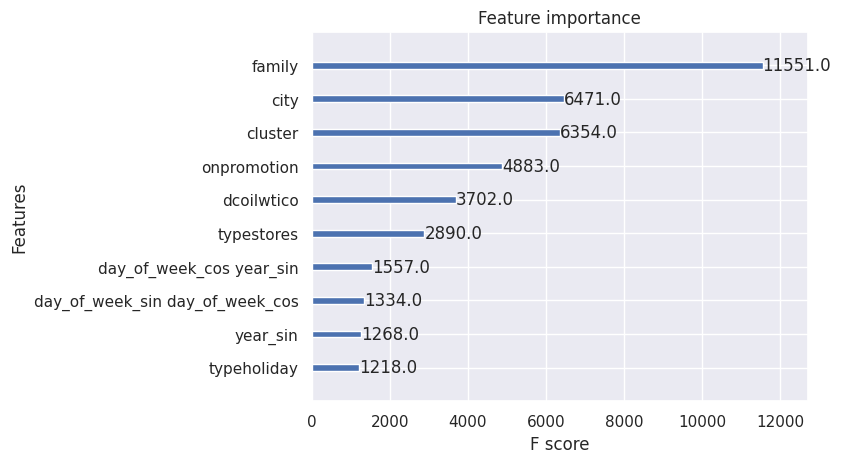

In [56]:
# ploting feature importances
_ = plot_importance(xgboost_v00,max_num_features = 10)

### Measuring Performance of XGBoost Regressor

In [57]:
# creating to dataframe, I will use to visualise predictions vs actual
series_compare=pd.concat([y_train,y_valid], axis=0)
df_compare=pd.DataFrame()
df_compare["actual"]=series_compare
df_compare["date"]=train_merged.date

In [58]:
# predicting validation set
y_pred_xgb = xgboost_v00.predict(X_valid)
# converting negative predictions to 0
y_pred_xgb=np.where(y_pred_xgb<0,0,y_pred_xgb)
# calculating metrics
calcMetrics(y_valid,y_pred_xgb)

RMSLE         MAE        RMSE        R2
0  0.971758  128.965031  453.124764  0.888202

In [59]:
# additing predictions to comparison dataframe
df_compare["xgb_pred"]=np.nan
df_compare.loc[df_compare.index>=df_compare.shape[0]-len(y_pred_xgb),"xgb_pred"]=y_pred_xgb
df_compare=df_compare.set_index("date")

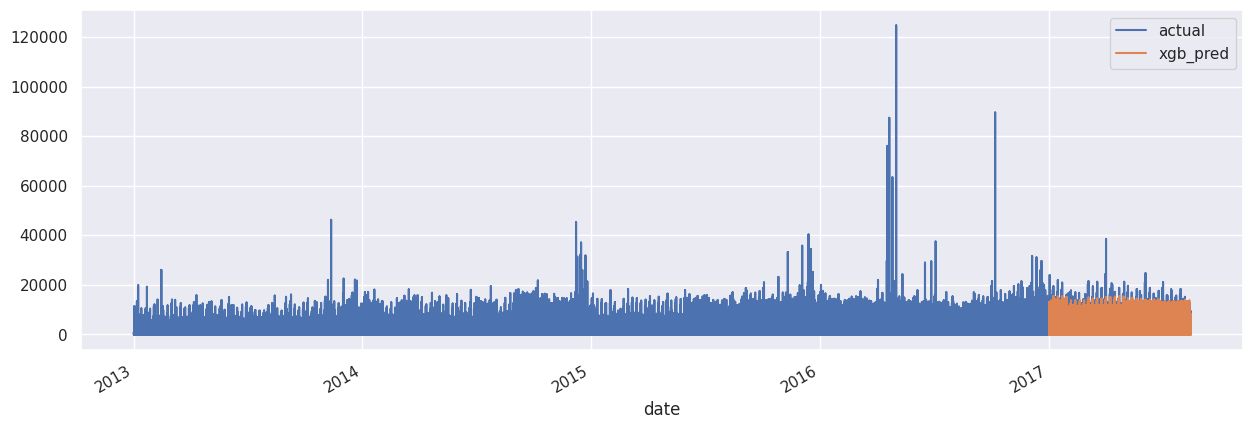

In [60]:
# visualising predictions
_ = df_compare[['actual','xgb_pred']].plot(figsize=(15, 5))

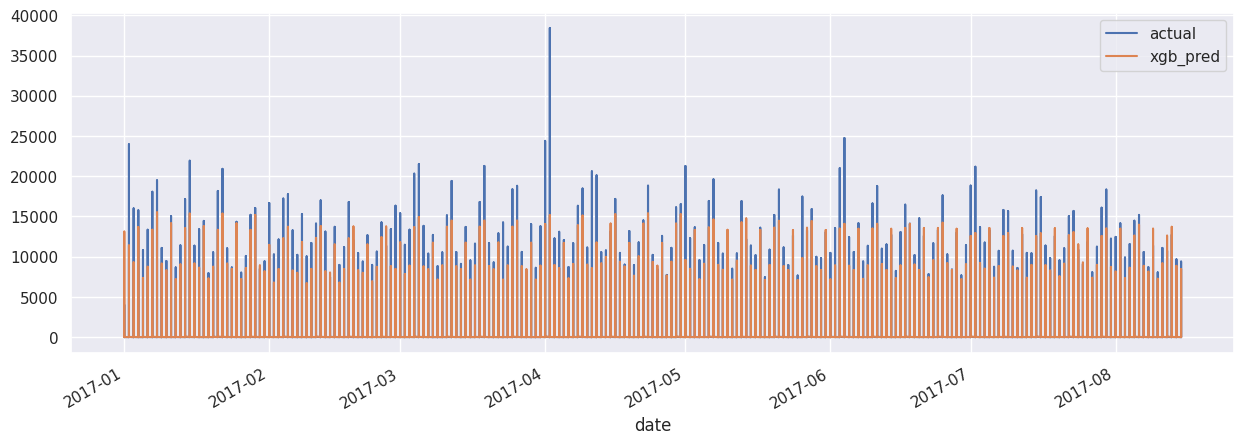

In [61]:
#zooming to 2017 afterwards that was predicted
_ = df_compare[['actual','xgb_pred']].tail(len(y_pred_xgb)).plot(figsize=(15, 5))

### Predicting Test Set with XGBoost Regressor

In [62]:
# preprocessing test set to rdy for inputting to model
X_test=preprocess_pipe.transform(test_merged[col_names_classic_ml])
#predicting testset
y_pred_test_xgb = xgboost_v00.predict(X_test)

In [63]:
# writing predictions to a csv for submission
output = pd.DataFrame({'id': test.id, 'sales': y_pred_test_xgb})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [64]:
# saving the model into a pickle file 
filename= 'StoreSales_XGB.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(xgboost_v00, handle, pickle.HIGHEST_PROTOCOL)
# removing model to free memory, 
del xgboost_v00

Public score: 0.94056

# DNN Model : Univariate LSTM - CNN hybrit model

* To incorporate impact of category features into lstm-cnn hybrid dnn, I will create a feature by merging 3 most important category feature together
* To train a dnn for each class in this new featrue, first I will discretise target encode new_feature, then discretise it into bins. This will group classes with similar sales figures together and reduce the number of models needed to be trained

### Preprocessing for DNN

In [65]:
# reading processed datasets
#train_merged=pd.read_csv("train_merged.csv")
#test_merged=pd.read_csv("test_merged.csv")

# converting extracted time features to float
#time_columns=["month","day_of_week","year"]
#for column in time_columns:
#    train_merged[column] = train_merged[column].astype('float')
#    test_merged[column] = test_merged[column].astype('float')
    
# converting category columns to str type
#category_columns=['family', 'typeholiday', 'city', 'typestores', 'cluster']
#for column in category_columns:
#    train_merged[column] = train_merged[column].astype('str')
#    test_merged[column] = test_merged[column].astype('str')

In [66]:
# making a copy of dataset I prepered before for training
dnn_df=train_merged.copy()
df_dnn_test_check=test_merged.copy()
# removing the 2nd copy to free memory
del train_merged
del test_merged
dnn_df["cat_gen"]=dnn_df["family"]+dnn_df["city"]+dnn_df["cluster"]
display(f'store_nbr nunique: {train["store_nbr"].nunique()}, family nunique: {dnn_df["family"].nunique()}, city nunique: {dnn_df["city"].nunique()}, cluster nunique: {dnn_df["cluster"].nunique()}, cat_gen nunique: {dnn_df["cat_gen"].nunique()}')

'store_nbr nunique: 54, family nunique: 33, city nunique: 22, cluster nunique: 17, cat_gen nunique: 1353'

In [67]:
#col_names_dnn=['cat_gen', 'family','typeholiday', 'city','typestores', 'cluster','dcoilwtico', 'date','day_of_week', 'month', 'year']
col_names_dnn=['cat_gen', 'date']
dnn_df_x=dnn_df[col_names_dnn]
dnn_df_y=dnn_df["sales"]

In [68]:
# sub pipeline to apply said transformation on derived feature
category_feat_dnn=Pipeline(steps=[("target_encode",TargetEncoder(target_type="continuous")),
                                 ("combiner",KBinsDiscretizer(n_bins=130, strategy='kmeans',
                                  subsample=None, random_state=seed0,encode='ordinal'))
                                 ])

In [69]:
# engineering the said feature in pipeline
preprocess_pipe_dnn = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("category_trans",category_feat_dnn,["cat_gen"])
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns =  col_names_dnn)))
                            ],verbose = True)

In [70]:
# converting date to string to avoid it getting transformed to float
dnn_df_x = dnn_df_x.astype({'date':'string'})
preprocess_pipe_dnn.fit(dnn_df_x,dnn_df_y)

[Pipeline] ........... (step 1 of 2) Processing encoder, total=   7.4s
[Pipeline] ....... (step 2 of 2) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_trans',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder(target_type='continuous')),
                                                                  ('combiner',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=130,
                                                                                    random_state=1337,
                                                                                    strategy='kmeans',
                                                                                    subsample=None))]),
                                                  ['cat_gen'])])),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x7f6446e1a940>))],
         verbose=True)

In [71]:
# checking if the ordering of feature names are correct
display(preprocess_pipe_dnn['encoder'].feature_names_in_)
display(preprocess_pipe_dnn['encoder'].get_feature_names_out())

array(['cat_gen', 'date'], dtype=object)

array(['category_trans__cat_gen', 'remainder__date'], dtype=object)

In [72]:
dnn_df_x=preprocess_pipe_dnn.transform(dnn_df_x)
display(dnn_df_x.head(2),dnn_df_x.tail(2),dnn_df_x.shape )

cat_gen        date
0     0.0  2013-01-01
1     0.0  2013-01-01

cat_gen        date
3000886     0.0  2017-08-15
3000887     0.0  2017-08-15

(3000888, 2)

In [73]:
dnn_training_features= ['cat_gen', 'date']
dnn_df_x=dnn_df_x[dnn_training_features]
#concatenating X-y datasets
dnn_df_processed=pd.concat([dnn_df_x,dnn_df_y], axis=1)
# converting date to datetime dtype
dnn_df_processed["date"] = pd.to_datetime(dnn_df_processed.date)
dnn_df_processed["sales"] = dnn_df_processed["sales"].astype(np.float32)
dnn_df_processed.head(2)

cat_gen       date  sales
0     0.0 2013-01-01    0.0
1     0.0 2013-01-01    0.0

In [74]:
# removing to free memory
del dnn_df_x
del dnn_df_y

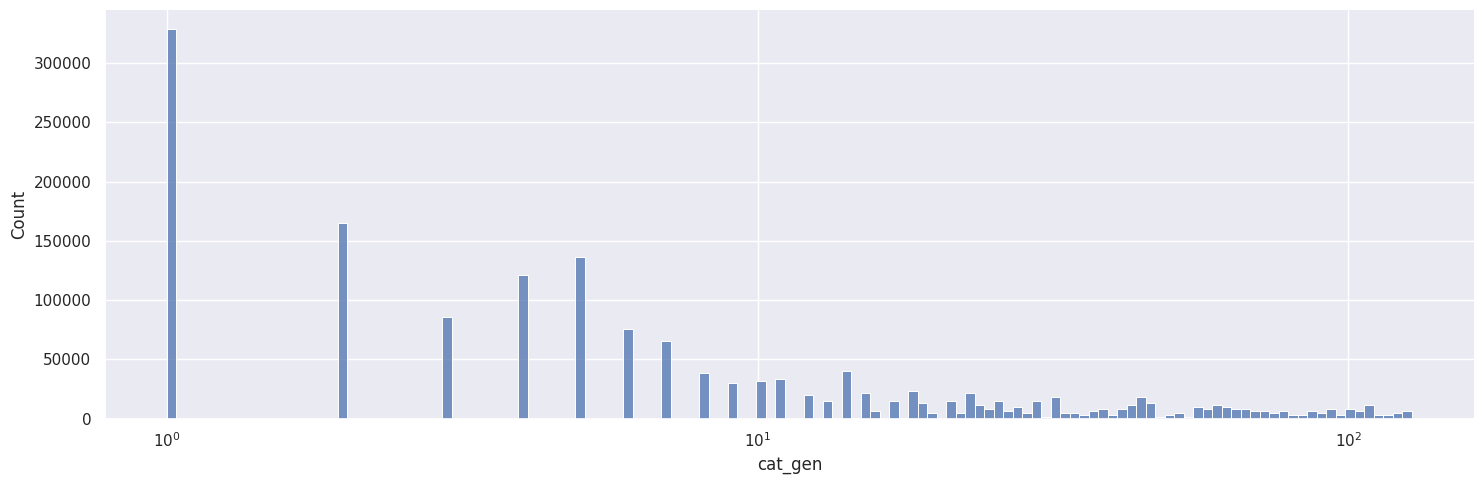

In [75]:
sns.displot(data=dnn_df_processed, x="cat_gen", log_scale=True, aspect=3)# , discrete=True)

In [76]:
# checking number of samples in each class of derived feature
display(dnn_df_processed["cat_gen"].value_counts() , dnn_df_processed["cat_gen"].nunique())

cat_gen
0.0      1337096
1.0       328380
2.0       165032
5.0       136404
4.0       121248
          ...   
116.0       1684
61.0        1684
99.0        1684
74.0        1684
31.0        1684
Name: count, Length: 101, dtype: int64

101

In [77]:
# applying the same transformations to test dataset
df_dnn_test_check["cat_gen"]=df_dnn_test_check["family"]+df_dnn_test_check["city"]+df_dnn_test_check["cluster"]
df_dnn_test_check = df_dnn_test_check.astype({'date':'string'})
df_dnn_test_check=preprocess_pipe_dnn.transform(df_dnn_test_check)
df_dnn_test_check=df_dnn_test_check[dnn_training_features]
df_dnn_test_check["date"] = pd.to_datetime(df_dnn_test_check.date)
# checking if train have any class that test don't have, if so I will remove it
display(f"test: {df_dnn_test_check['cat_gen'].nunique()}")
display(f"train: {dnn_df_processed['cat_gen'].nunique()}")

'test: 101'

'train: 101'

There is no category bin that is in train but not in test

In [78]:
# I will use the 95 day from end of train dataset time series for validation 
Test_sample_size=95
SPLIT_DATE=pd.to_datetime("2017-08-15")-pd.to_timedelta((Test_sample_size), unit='d')
Train_sample_size =365*4+1
Training_interval=pd.to_timedelta((Train_sample_size), unit='d')
train_data_begin_date=SPLIT_DATE-Training_interval
display(f"train_data_begin_date: {train_data_begin_date}")
dnn_df_processed=dnn_df_processed.loc[dnn_df_processed["date"]>=train_data_begin_date]
display(dnn_df_processed.head(2))
#creating a copy of processed dataset for ease of access to unscaled features for later comparison, evaluation
dnn_df_processed_unscaled=dnn_df_processed.copy()
grouped_sample_lenght=len(dnn_df_processed_unscaled[dnn_df_processed_unscaled["cat_gen"]==0].groupby("date")[['cat_gen','sales']].agg({'cat_gen':'mean', 'sales':'median'}))
display(f"lenght of dataframes grouped by cat_gen: {grouped_sample_lenght}")

'train_data_begin_date: 2013-05-12 00:00:00'

cat_gen       date  sales
233442     0.0 2013-05-12    1.0
233443     0.0 2013-05-12    0.0

'lenght of dataframes grouped by cat_gen: 1553'

In [79]:
#defining parameters for training
SPLIT_TIME =grouped_sample_lenght-Test_sample_size
WINDOW_SIZE = 16
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 580

In [80]:
# helper function to devide train dataset into sub-datasets for each class in derived category
# and grouping by date by taking the median of sales
def create_datasets(df):
    dnn_data_sets={}
    fitted_scalers={}
    for val in df["cat_gen"].unique():
        df_segment=df[df["cat_gen"]==val]
        df_segment_grouped=df_segment.groupby("date")[['cat_gen','sales']].agg({'cat_gen':'mean', 'sales':'median'})
        df_segment_grouped=df_segment_grouped.drop(columns=['cat_gen'])
        scaler=MinMaxScaler()
        scaler.fit(df_segment_grouped[["sales"]])
        fitted_scalers[val]=scaler
        df_segment_grouped["sales"]=scaler.transform(df_segment_grouped[["sales"]])
        df_segment_grouped["sales"] = df_segment_grouped["sales"].astype(np.float32)
        dnn_data_sets[val]=df_segment_grouped
    return dnn_data_sets , fitted_scalers
dnn_data_sets, fitted_scalers=create_datasets(dnn_df_processed) 

In [81]:
# printing a sample of sub-datasets shape info
Sample_of_df_dict=np.random.choice([x for x in dnn_data_sets.keys()], 10 ,replace=False)
for key in Sample_of_df_dict:
    display(f"{key} : {dnn_data_sets[key].shape}")

'108.0 : (1553, 1)'

'28.0 : (1553, 1)'

'47.0 : (1553, 1)'

'33.0 : (1553, 1)'

'40.0 : (1553, 1)'

'60.0 : (1553, 1)'

'75.0 : (1553, 1)'

'71.0 : (1553, 1)'

'11.0 : (1553, 1)'

'80.0 : (1553, 1)'

In [82]:
# verifying number of samples to be used for training and validation
len_test=len(dnn_data_sets[0][dnn_data_sets[0].index <=SPLIT_DATE])
display(f"train size: {len_test}, test size: {dnn_data_sets[0].shape[0]-len_test}")

'train size: 1458, test size: 95'

In [83]:
# helper function to parse dataframes to extract time and series
def parse_df(df):
    times =np.array([x for x in range(df.shape[0])])
    series=df["sales"].to_numpy()
    return times, series

In [84]:
# helper function to devide time and series to train test splits according to time-step
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

In [85]:
# helper function to create windowed dataset tensors from series by shifting according to window size 
# and create batches from it for training
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [86]:
tf.keras.backend.clear_session()
# helper function to create and compile dnn model
def create_model(WINDOW_SIZE):
    drop_out=0
    activation=LeakyReLU(alpha = 0.01)
    regularizer=regularizers.l2(1e-4)
    model = tf.keras.models.Sequential([
              #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
              #            input_shape=[WINDOW_SIZE]),
              tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation=activation,
                          padding='causal',
                          input_shape=[WINDOW_SIZE, 1]),
              tf.keras.layers.LSTM(64, return_sequences=True, dropout=drop_out),
              tf.keras.layers.LSTM(64,dropout=drop_out),
              tf.keras.layers.Dense(30, activation=activation, kernel_regularizer = regularizer),
              tf.keras.layers.Dense(10, activation=activation, kernel_regularizer = regularizer),
              tf.keras.layers.Dense(1)
        ])
    learning_rate = 1e-3
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["mae"])
    return model
# note: conv1d layer return lstm input in appropriate shape for lstm
# without conv1d layer a lambda layer will be needed to reshape input for lstm, code commented is for this lambda layer

In [87]:
# callback function to avoid any memory leak issue and reset states in tf.keras
class ClearMemory(Callback):
    def on_train_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [88]:
# call back function to avoid overfitting by early stopping and reduce learning rate on plateau to help convergence
def call():
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # metrics to monitor
    patience=20, # how many epochs before stop
    verbose=1,
    mode='min', 
    restore_best_weights=True)
    
    # reducing learning rate on plateau
    rp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # halving learning rate on plateau
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-8)
    return es,rp

In [89]:
# generator function to iterate memory efficently
def ited_dict(dict):
    for key,value in dict.items():
        yield key, value

In [90]:
# helper function to train model for each class in derived category
# calls the functions above in correct sequence and saves the models and training history to dictionaries 
def train_all(dnn_data_sets,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE, SPLIT_TIME):
    compiled_models_dict={}
    history_dict={}
    total_num_models=len(dnn_data_sets)
    num_model_to_train=total_num_models
    for key,df in ited_dict(dnn_data_sets):
        print(f"Number of models remained to be trained {num_model_to_train} out of {total_num_models} remained")
        print(f"Training: {key}")
        times, sales = parse_df(df)
        TIME = np.array(times)
        SERIES = np.array(sales)
        
        time_train, series_train, time_valid, series_valid =train_val_split(TIME, SERIES, time_step=SPLIT_TIME)
        
        train_set = windowed_dataset(series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, 
                                     shuffle_buffer=SHUFFLE_BUFFER_SIZE)
        
        valid_set = windowed_dataset(series_valid, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, 
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)
        
        model = create_model(WINDOW_SIZE)
        callbacks = call()
        history = model.fit(train_set, epochs=100, verbose=1,validation_data=valid_set, callbacks=[callbacks,ClearMemory()])
        compiled_models_dict[key]=model
        del model
        history_dict[key]=history
        del history
        num_model_to_train-=1
        IPython.display.clear_output()
        gc.collect()
        tf.keras.backend.clear_session()
    print(f"Trainings finnished: {len(compiled_models_dict)} models trained.")        
    return compiled_models_dict, history_dict

In [91]:
compiled_models_dict, history_dict=train_all(dnn_data_sets,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE, SPLIT_TIME)

Trainings finnished: 101 models trained.


In [92]:
# Helper function to plot loss graphs 
def plot_loss_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    plt.close()

128.0


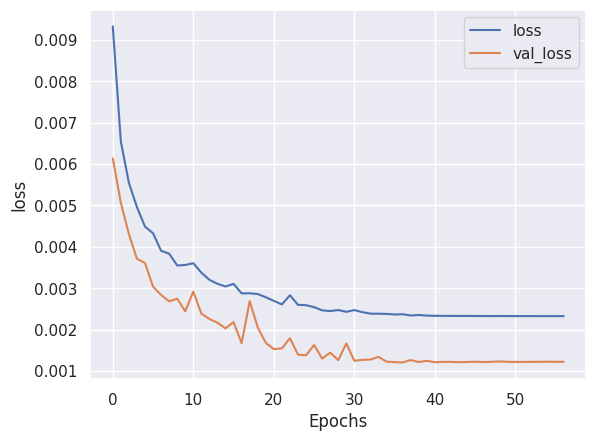

1.0


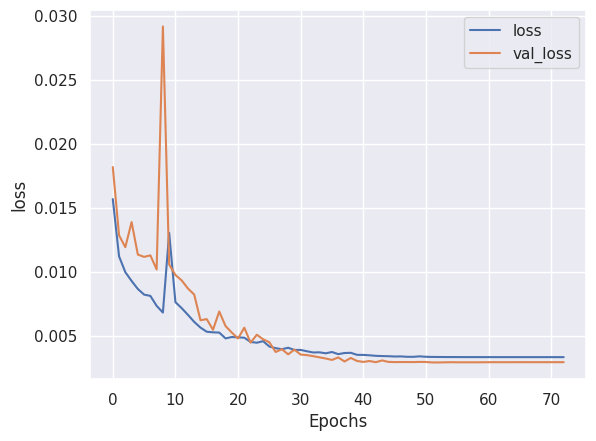

31.0


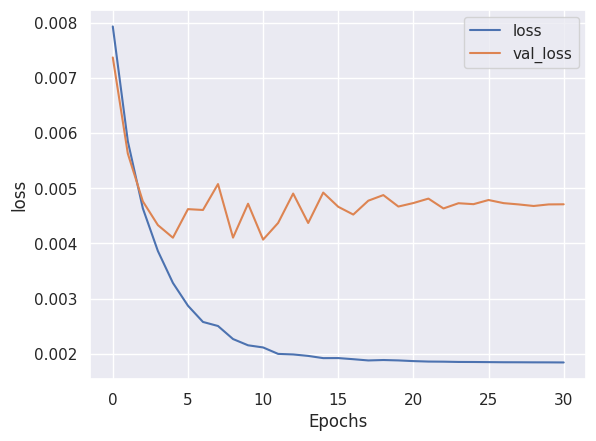

23.0


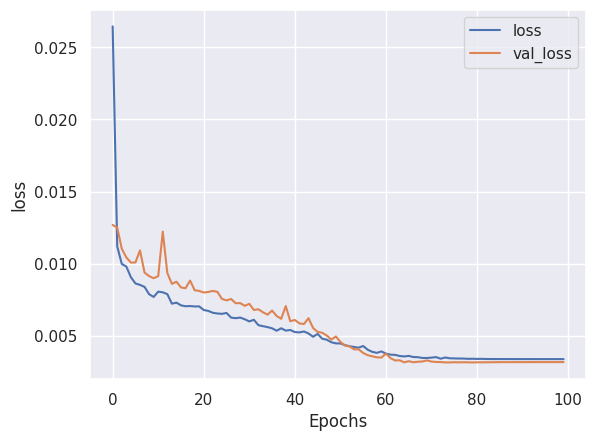

29.0


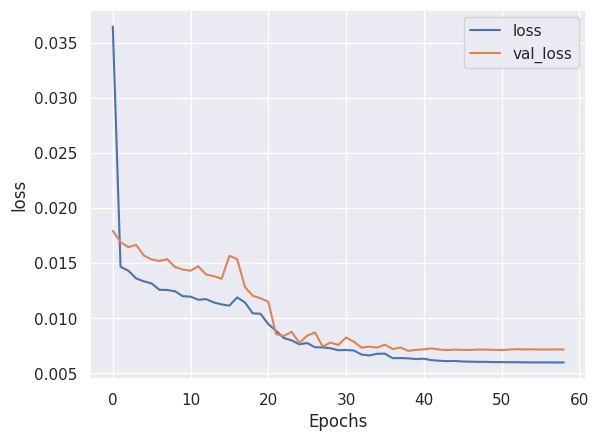

46.0


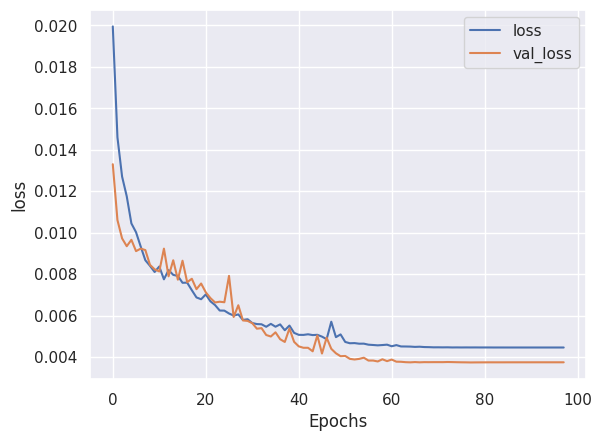

107.0


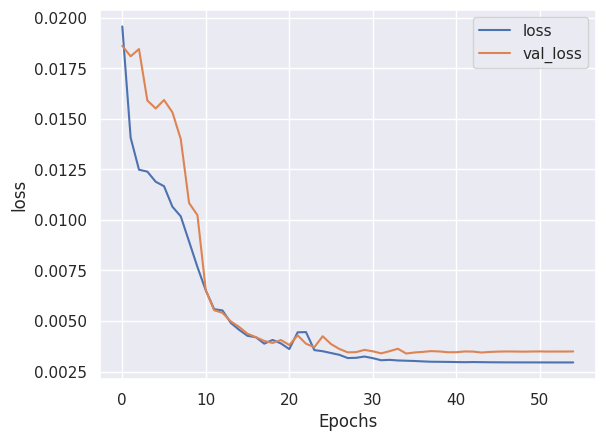

0.0


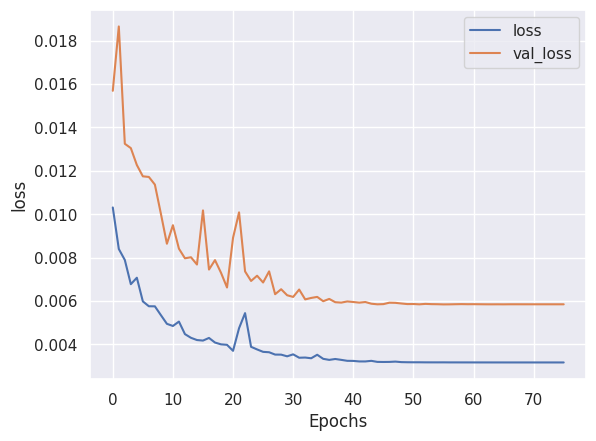

115.0


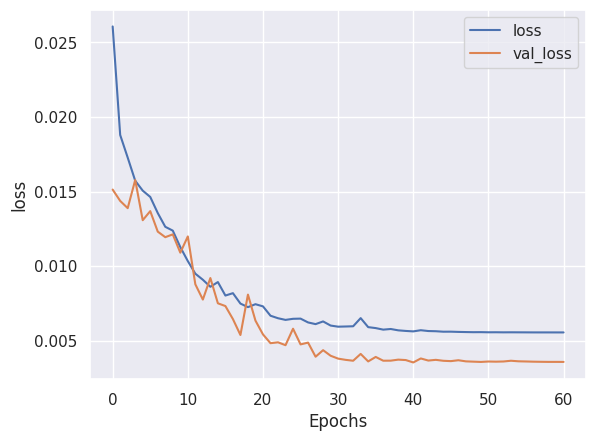

65.0


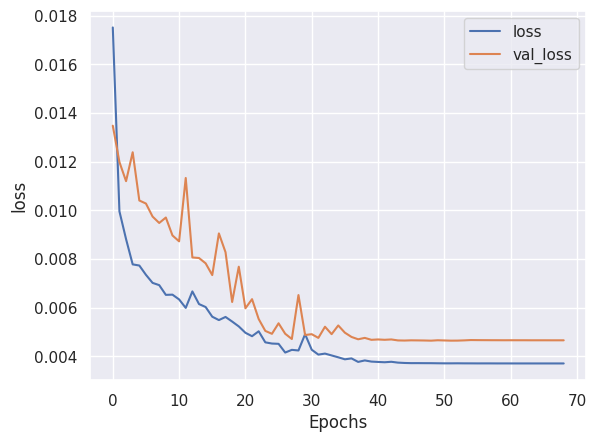

In [93]:
# printing 10 randomly selected loss map
Sample_of_loss_graphs=np.random.choice([x for x in history_dict.keys()], 10 ,replace=False,)
for key in Sample_of_loss_graphs:
    print(key)
    plot_loss_graphs(history_dict[key], "loss")

In [94]:
# removing to free memory
del history_dict

In [95]:
# helper function for to create windowed dataset without shuffling for fast forecasting 
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(8).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [96]:
#  helper function that calls required helper methods in correct sequence
# and return a forecast for series after split_time (validation data)
def predict_results(models_dict,dnn_data_sets, WINDOW_SIZE,SPLIT_TIME,fitted_scalers):
    predictions={}
    total_num_models=len(dnn_data_sets)
    num_model_to_train=total_num_models
    for key,model in ited_dict(models_dict):
        print(f"Number of datasets remained to be predicted {num_model_to_train} out of {total_num_models} remained")
        print(f"Predicting: {key}")
        times, sales = parse_df(dnn_data_sets[key])
        TIME = np.array(times)
        SERIES = np.array(sales)
        
        dnn_forecast = model_forecast(model,SERIES, WINDOW_SIZE).squeeze()
        dnn_forecast = dnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1]
        
        predictions_df=pd.DataFrame(index=dnn_data_sets[key][SPLIT_TIME :].index)
        predictions_df["predictions"]=dnn_forecast
        del dnn_forecast
        predictions_df["predictions"]=fitted_scalers[key].inverse_transform(predictions_df[["predictions"]])
        predictions_df["predictions"]=np.where(predictions_df["predictions"]<0,0,predictions_df["predictions"])
        predictions[key]=predictions_df
        num_model_to_train-=1
        IPython.display.clear_output()
        gc.collect()
    print(f"Predictions finnished: {len(predictions)} dataset predicted.") 
    return predictions

In [97]:
predictions_dict=predict_results(compiled_models_dict,dnn_data_sets, WINDOW_SIZE,SPLIT_TIME, fitted_scalers)

Predictions finnished: 101 dataset predicted.


In [98]:
#helper function to plot time series actual vs time series predicted 
def plot_series_multi(time1, series1,series2,label1, label2, format1="--",format2="-", start=0, end=None ):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_axes([1, 1, 1, 1])
    ax.plot(time1[start:end], series1[start:end])
    ax.plot(time1[start:end], series2[start:end])
    ax.legend(labels = (label1, label2))
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

97.0


RMSLE         MAE       RMSE        R2
0  0.159553  650.497742  805.44549  0.351841

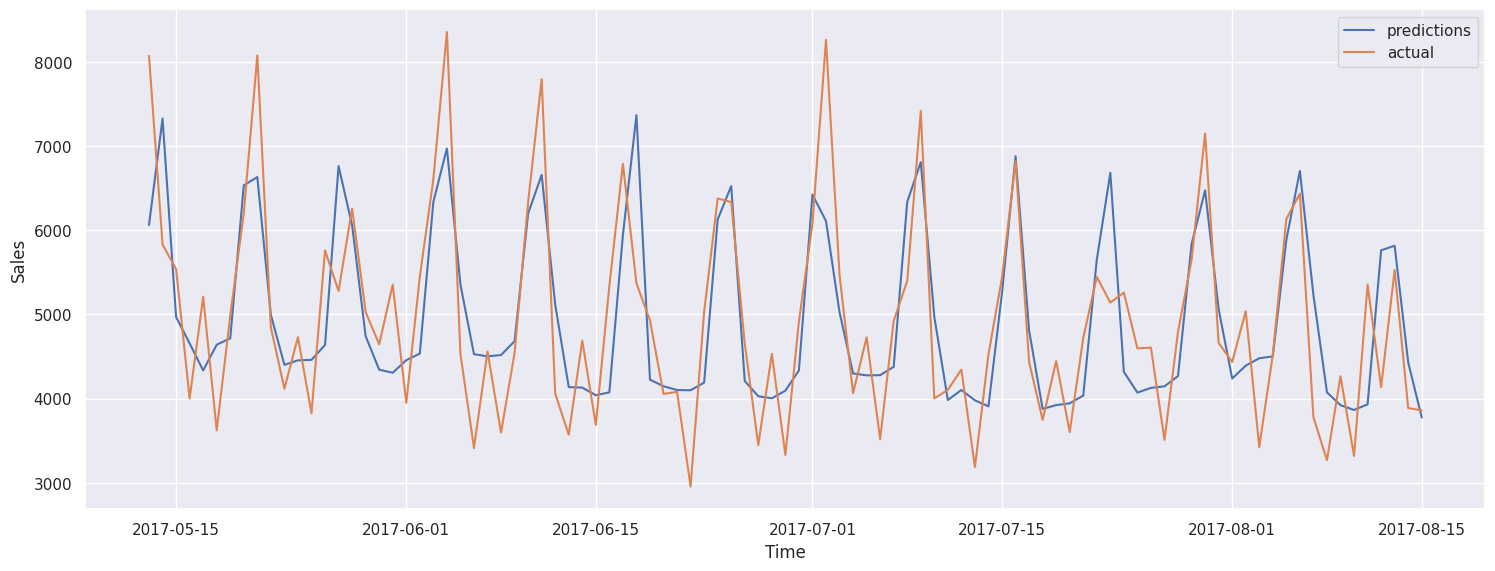

47.0


RMSLE         MAE        RMSE        R2
0  0.126433  263.794983  345.766777  0.588972

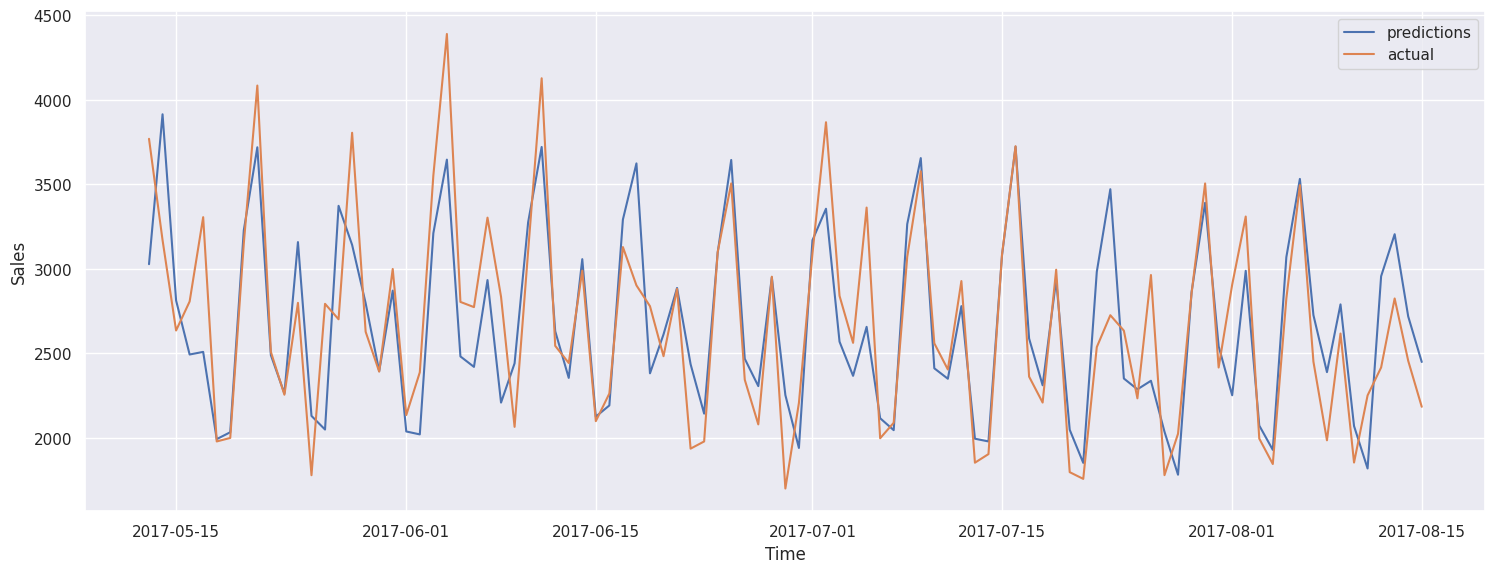

55.0


RMSLE         MAE        RMSE        R2
0  0.181048  360.294159  473.832496 -1.016146

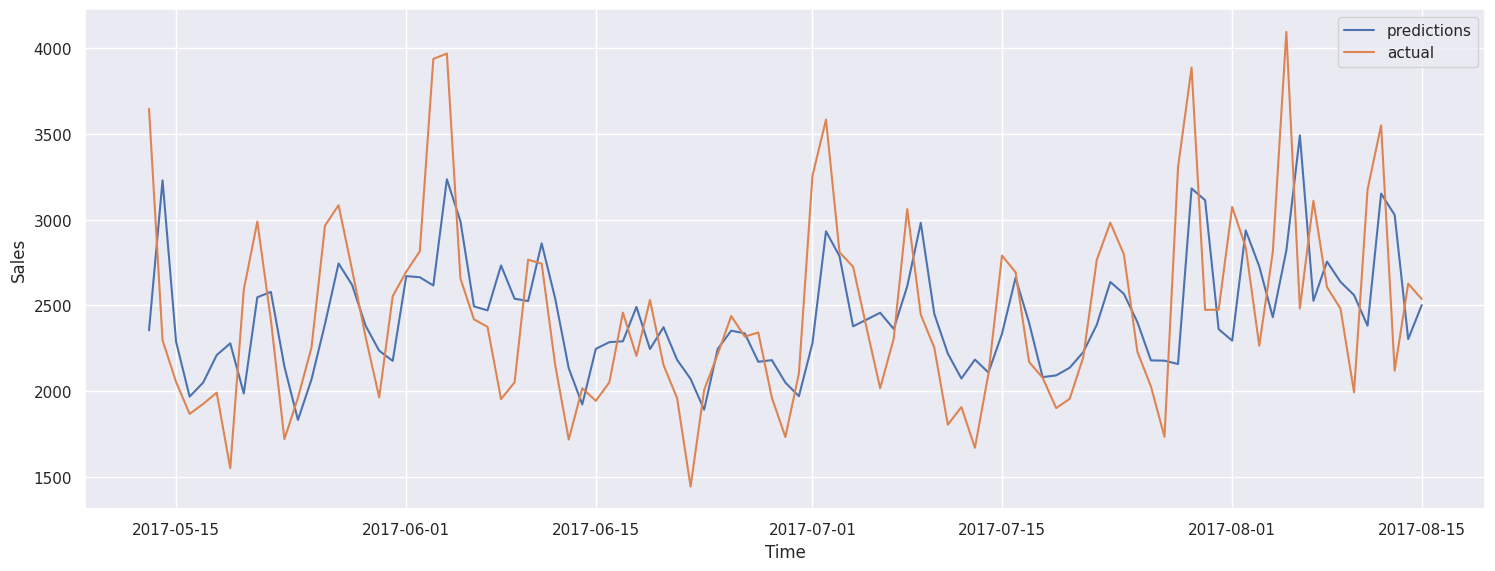

102.0


RMSLE          MAE         RMSE        R2
0  0.27176  1472.348999  1846.510696 -71.41257

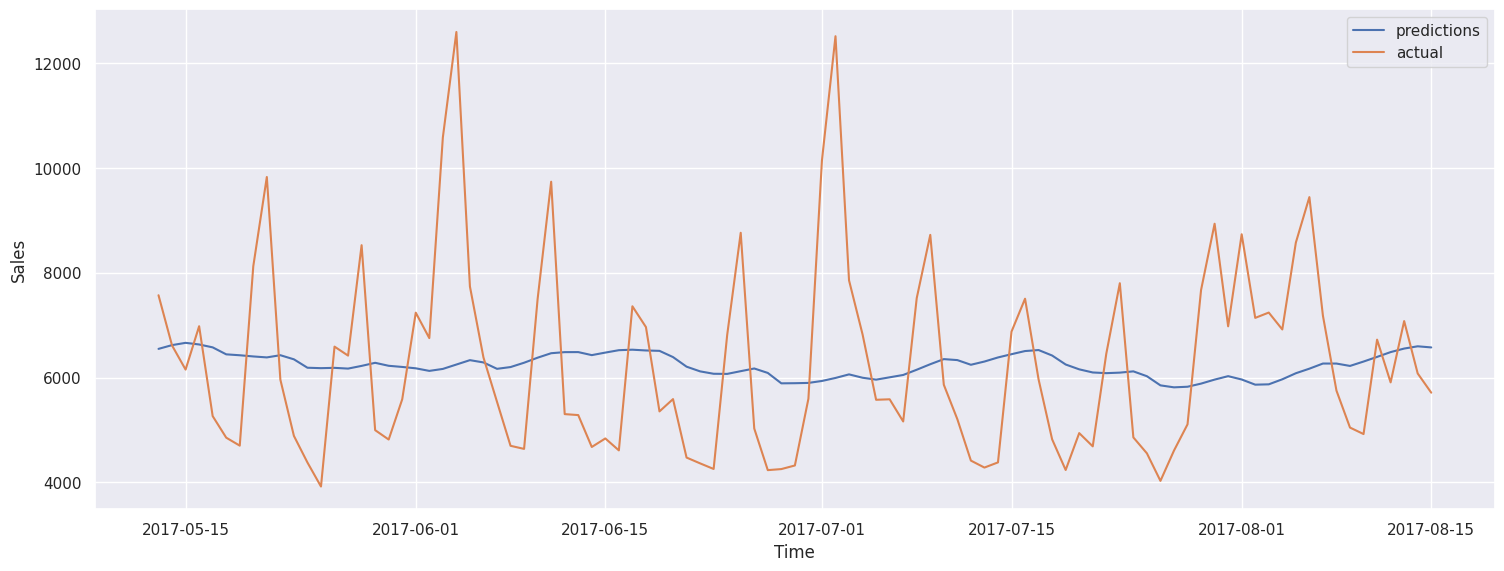

43.0


RMSLE         MAE        RMSE         R2
0  0.191225  253.006195  327.975645 -69.687044

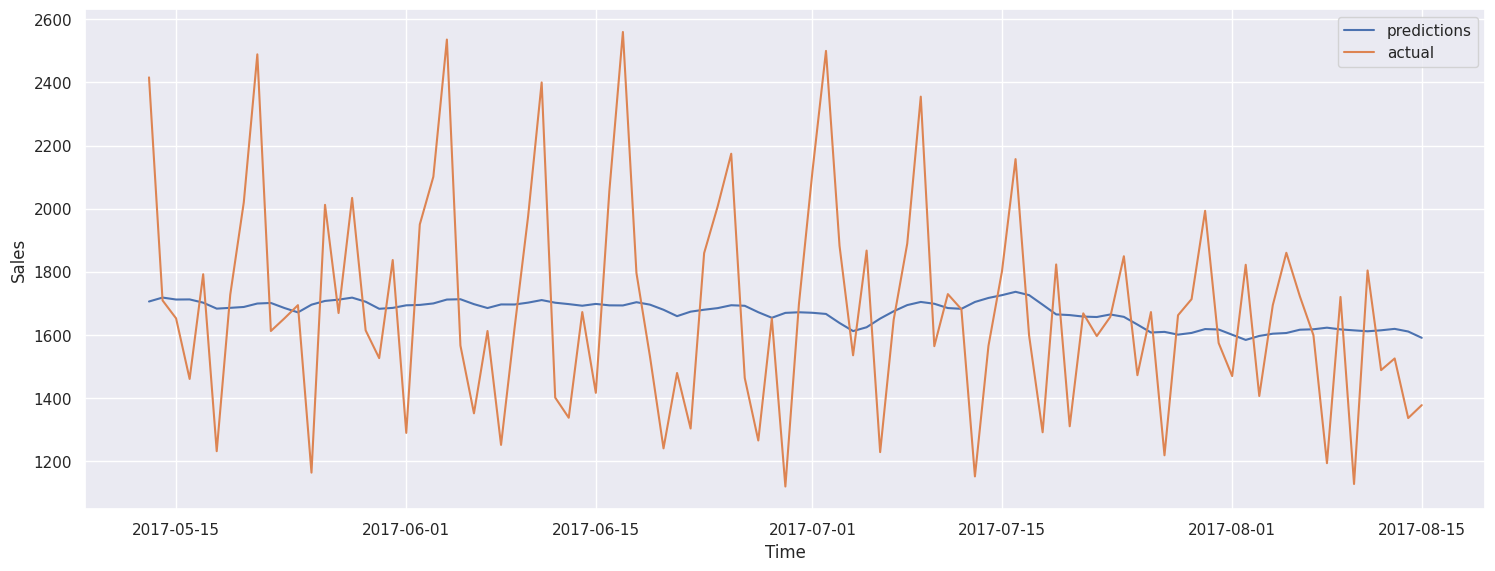

78.0


RMSLE         MAE        RMSE        R2
0  0.123242  312.898163  386.510127 -0.656186

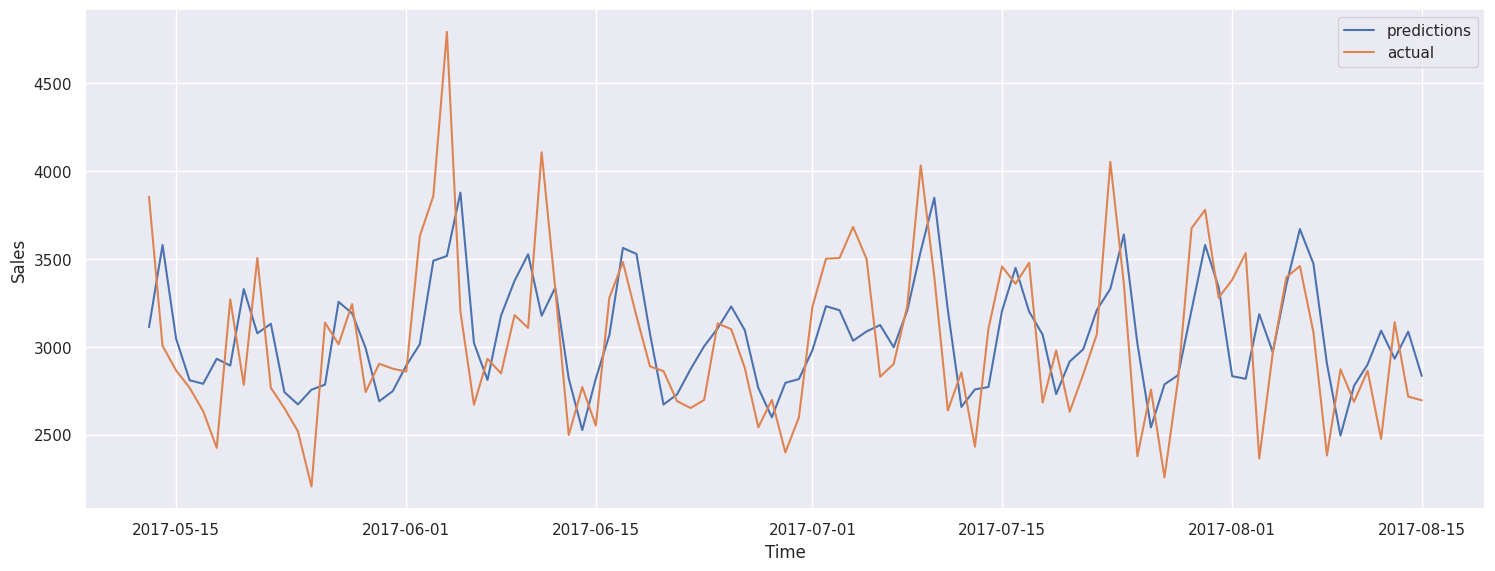

26.0


RMSLE         MAE        RMSE        R2
0  0.17071  155.412994  195.425557 -1.341204

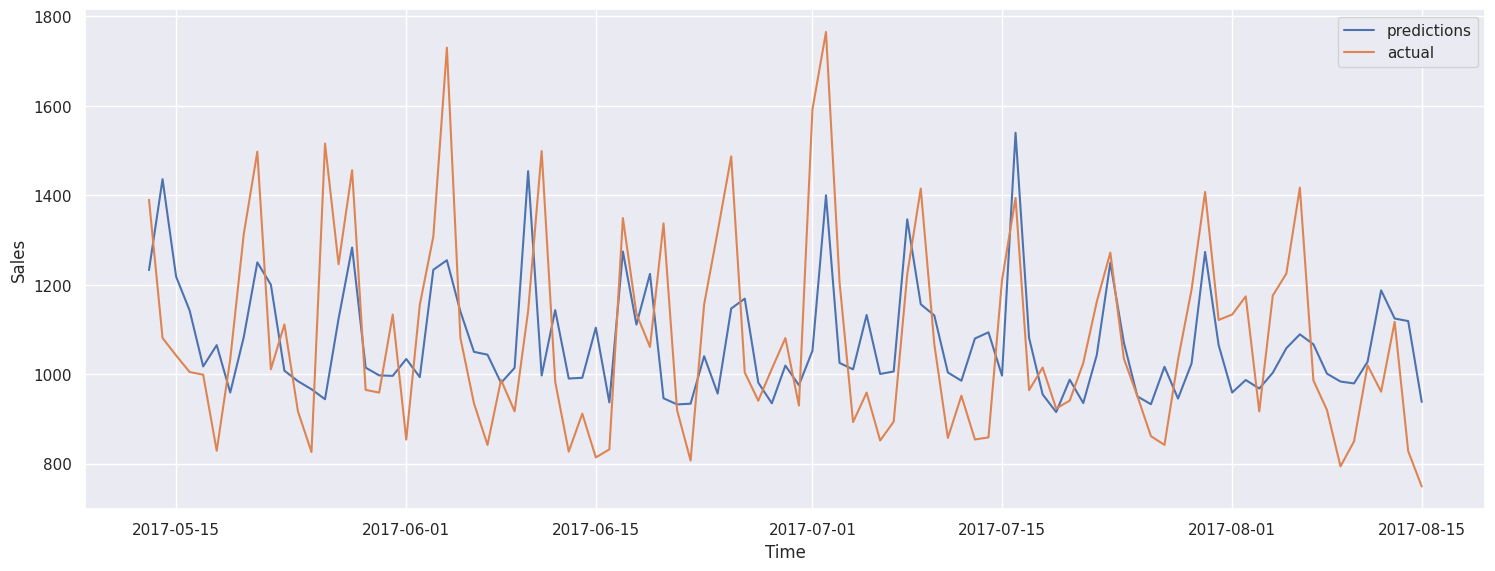

95.0


RMSLE         MAE         RMSE         R2
0  0.233532  887.851013  1142.941764 -47.089652

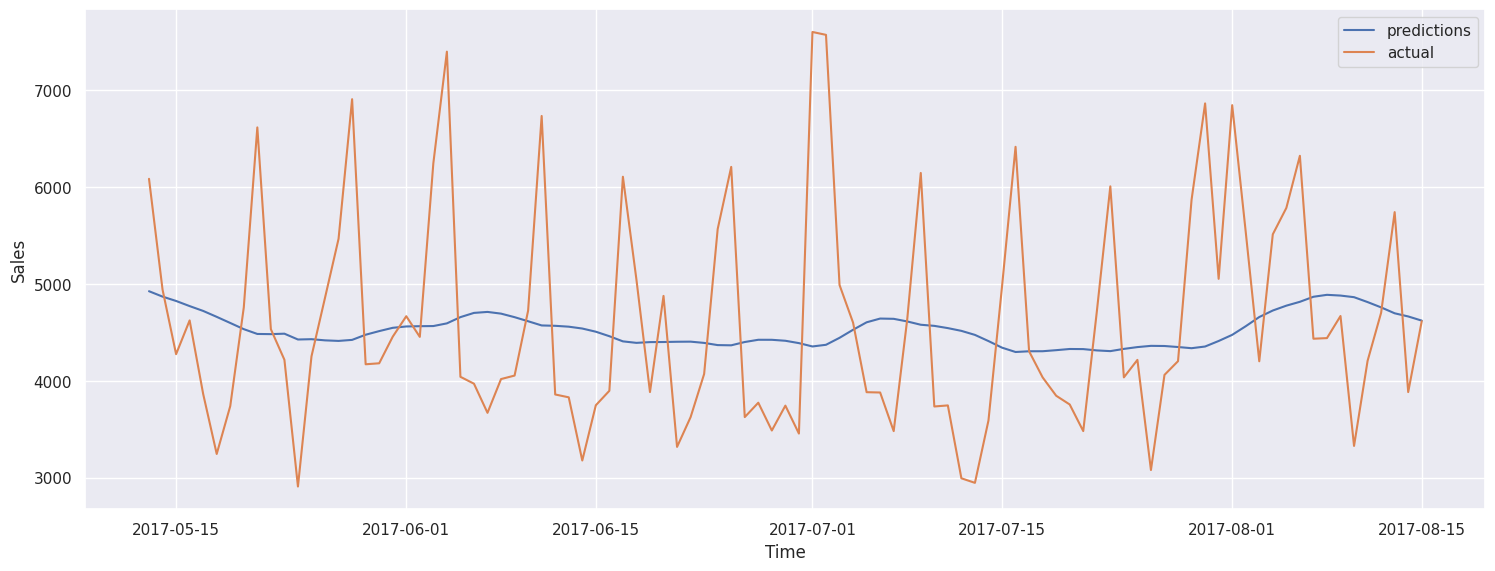

10.0


RMSLE        MAE       RMSE        R2
0  0.160464  59.346355  79.200778  0.349186

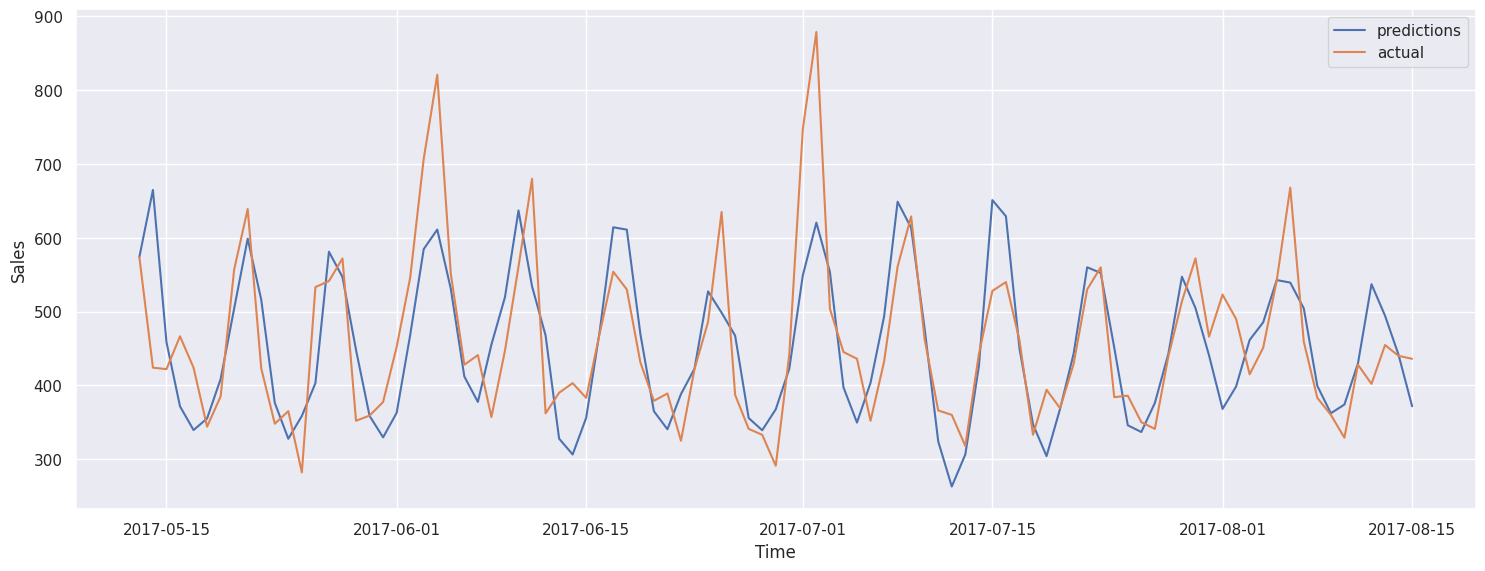

29.0


RMSLE         MAE        RMSE        R2
0  0.182878  163.378326  198.577372 -0.038326

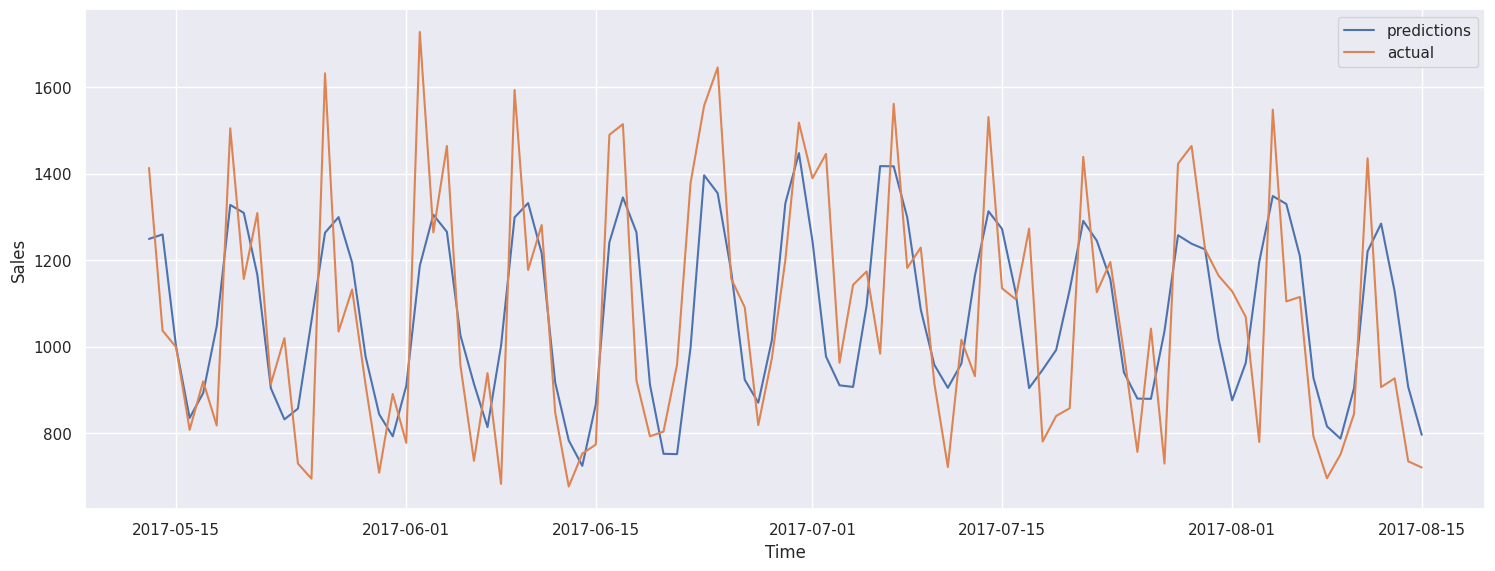

In [99]:
# printing out metrics and actual vs predicted time series graphs for a subsample of predictions for sub-grouped validation datasets
Sample_of_actual_predict_graphs=np.random.choice([x for x in predictions_dict.keys()], 10 ,replace=False,)
for key in Sample_of_actual_predict_graphs:
    #printing out metrics
    print(key)
    display(calcMetrics(predictions_dict[key].to_numpy(),
                        fitted_scalers[key].inverse_transform(dnn_data_sets[key]["sales"][SPLIT_TIME :].to_numpy().reshape(-1, 1))))
    
    time1=dnn_data_sets[key].index.values[SPLIT_TIME :]
    series1=predictions_dict[key].to_numpy()
    series2=fitted_scalers[key].inverse_transform(dnn_data_sets[key]["sales"][SPLIT_TIME :].to_numpy().reshape(-1, 1))
    # plotting the graph
    plot_series_multi(time1, series1,series2,"predictions","actual", format1="--",format2="-", start=0, end=None, )

In [100]:
# helper function for mapping predictions from sub-grouped datasets to ungrouped full dataset 
def aggragate_predictions(df_valid,predictions_dict):
    df_preds = pd.DataFrame(columns=['predictions'], index=df_valid.index.copy())
    for key,df in ited_dict(predictions_dict):
        for date in df.index:
            df_preds["predictions"]=np.where((df_valid["cat_gen"]==key) & (df_valid["date"]==date),
                                                   df.iloc[df.index.values==date]["predictions"].values[0] ,df_preds["predictions"])
    return df_preds["predictions"].to_numpy()

In [101]:
# helper function for creating ungrouped full validation dataset and parsing it into X and y
def val_dnn_processed(df):
    val_start_index=df.shape[0]-len(df["date"][df["date"] >SPLIT_DATE])
    val=df[val_start_index:]
    y_valid = val.pop("sales")
    X_valid = val
    return X_valid, y_valid 
X_valid_dnn, y_valid_dnn = val_dnn_processed(dnn_df_processed_unscaled)

In [102]:
# predicting full-validation datase and calculating metrics
y_pred_dnn=aggragate_predictions(X_valid_dnn,predictions_dict)
calcMetrics(y_pred_dnn,y_valid_dnn)

RMSLE         MAE        RMSE        R2
0  0.874084  130.527714  456.810926  0.862657

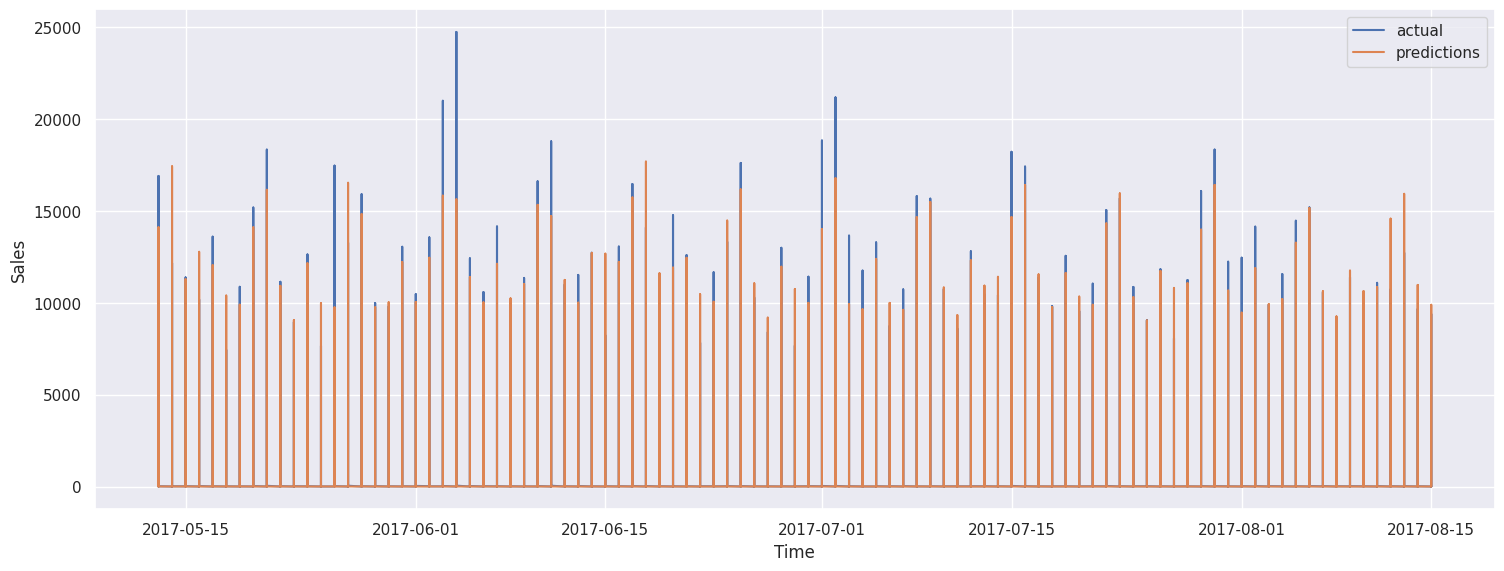

In [103]:
# plotting actual vs predictions for validation dataset
plot_series_multi(dnn_df_processed_unscaled.loc[dnn_df_processed_unscaled["date"]>SPLIT_DATE]["date"].values,
                   dnn_df_processed_unscaled.loc[dnn_df_processed_unscaled["date"]>SPLIT_DATE]["sales"].values, y_pred_dnn,
                  "actual","predictions",format1='r^',format2="b^", start=0, end=None )

### Predicting Test Set with Univariate LSTM - CNN hybrit model

In [104]:
# helper function to devide test into sub-datasets for each class in derived category
def create_grouped_test_datasets(df):
    dnn_data_sets={}
    for val in df["cat_gen"].unique():
        df_segment=df[df["cat_gen"]==val]
        df_segment_grouped=df_segment.groupby("date")[['cat_gen']].agg({'cat_gen':'mean'})
        df_segment_grouped=df_segment_grouped.drop(columns=['cat_gen'])
        dnn_data_sets[val]=df_segment_grouped
    return dnn_data_sets 
dnn_data_set_test =create_grouped_test_datasets(df_dnn_test_check) 

In [105]:
# helper function that returns predictions for testset for each class in derived category
def predict_results_test(models_dict,dnn_data_sets,dnn_data_set_test, WINDOW_SIZE,fitted_scalers):
    predictions={}
    for key, model in models_dict.items():
        times, sales = parse_df(dnn_data_sets[key])
        SERIES = np.array(sales)
        dnn_forecast = model_forecast(model,SERIES, WINDOW_SIZE).squeeze()
        dnn_forecast = dnn_forecast[-WINDOW_SIZE:]
        predictions_df=pd.DataFrame(index=dnn_data_set_test[key].index)
        predictions_df["predictions"]=dnn_forecast
        predictions_df["predictions"]=fitted_scalers[key].inverse_transform(predictions_df[["predictions"]])
        predictions_df["predictions"]=np.where(predictions_df["predictions"]<0,0,predictions_df["predictions"])
        predictions[key]=predictions_df 
    return predictions
predictions_dict_test=predict_results_test(compiled_models_dict,dnn_data_sets,dnn_data_set_test, WINDOW_SIZE,fitted_scalers)

193/193 [==============================] - 1s 4ms/step


In [106]:
# calling aggragate predictions function for mapping predictions from sub-grouped validation datasets to ungrouped full validation dataset
y_pred_dnn_test=aggragate_predictions(df_dnn_test_check,predictions_dict_test)

In [107]:
# writing predictions to a csv for submission
output = pd.DataFrame({'id': test.id, 'sales': y_pred_dnn_test})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Public score: 0.90424

In [110]:
# Saving models into pickle files
for key,model in ited_dict(compiled_models_dict): 
    docs_add=os.getcwd()+'/dnn_models/'
    filename= docs_add+str(key)+'.pkl'
    with open(filename, 'wb') as handle:
        pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)
# removing models to free memory 
del compiled_models_dict

# Concluding Discussion and Future Work:

Several potential enhancements can elevate the quality and scope of this study. One notable concern pertains to the extensive memory consumption of the DNN models' dictionary in my limited local environment. To manage this, I had to reduce the derived category feature's classes to 1/10 of the original count, consequently training fewer DNN models that could fit within my system's memory constraints. Expanding the memory capacity would facilitate training a greater number of models encompassing more classes within the derived category. This approach could enhance model specificity and potentially bolster accuracy.

Furthermore, an avenue for improvement lies in the utilization of multivariate models. While the current model operates as a univariate setup, incorporating the time-varying nature of oil prices as an input feature could notably enhance accuracy. This integration could offer valuable insights by capturing the contextual dynamics of oil price fluctuations within the forecasting framework.

Moreover, the incorporation of engineered transaction features could be a valuable addition to a multivariate model. This inclusion could potentially introduce significant time-varying aspects that may augment the model's predictive capabilities, especially when combined with other relevant variables.

In summary, future endeavors could focus on optimizing memory utilization for more expansive model training, transitioning to multivariate models to incorporate additional impactful features such as oil prices, and exploring the incorporation of transaction-based engineered features to enhance predictive accuracy and robustness. These improvements hold the potential to refine the forecasting models and yield more nuanced and accurate predictions.